# 🌍 Phase 9C: Cross-Site Generalization Evaluation

## Multi-Dataset External Validation for Robust Medical Imaging

**Author:** Viraj Pankaj Jain  
**Institution:** University of Glasgow, School of Computing Science  
**MSc Dissertation:** Tri-Objective Robust XAI for Medical Imaging  
**Date:** December 2024

---

### 📋 Research Questions Validated

| RQ | Hypothesis | Description |
|----|-----------|-------------|
| **RQ1c** | H1c | Tri-objective improves cross-site generalization vs Baseline |
| **RQ4** | External Validity | Models maintain performance on unseen data distributions |

### 🎯 Evaluation Objectives

This notebook evaluates **cross-site generalization** - the ability of trained models to perform well on data from different sources than the training data:

1. **In-Domain (ISIC 2018)**: Same distribution as training data
2. **Cross-Site (ISIC 2019)**: Different year, different imaging equipment
3. **Cross-Site (ISIC 2020)**: Most recent challenge, different patient populations

### 📊 Key Hypothesis

> **H1c**: Tri-objective model achieves **lower AUROC drop** when generalizing to cross-site data compared to Baseline and TRADES.

**Rationale**: Higher clean accuracy (76% vs 62% TRADES) suggests better learned features that may generalize better despite lower adversarial robustness.

### 📈 Expected Deliverables

- **Table 6**: Cross-site AUROC comparison across all datasets
- **Table 7**: Statistical significance tests (paired t-tests)
- **Figure 6**: AUROC drop comparison bar charts
- **Figure 7**: Generalization gap analysis heatmap

---

### ⚙️ Environment Requirements

- **GPU**: Google Colab T4/V100/A100
- **Data**: ISIC 2018, 2019, 2020 on Google Drive
- **Checkpoints**: 9 models (3 approaches × 3 seeds)

In [15]:
# ============================================================================
# CELL 1: GOOGLE COLAB ENVIRONMENT SETUP
# ============================================================================
# 🚀 Production-quality environment initialization for cross-site evaluation
# ============================================================================

"""
===============================================================================
PHASE 9C: CROSS-SITE GENERALIZATION EVALUATION
===============================================================================
Objective: Evaluate all models (Baseline, TRADES, Tri-Objective) on:
  - ISIC 2018 (in-domain test)
  - ISIC 2019 (cross-site / out-of-distribution)
  - ISIC 2020 (cross-site / out-of-distribution)

Key Hypothesis: Tri-objective may generalize BETTER than TRADES despite
lower robustness, due to higher clean accuracy (76% vs 62%).

Statistical Framework:
  - 3 seeds per approach for statistical robustness
  - Paired t-tests for significance testing
  - Cohen's d for effect size quantification
===============================================================================
"""

import os
import sys
import json
import warnings
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional, Any, Union
from collections import defaultdict

warnings.filterwarnings('ignore')

# ============================================================================
# 1.1 Environment Detection & Configuration
# ============================================================================
print("=" * 80)
print("🌍 PHASE 9C: CROSS-SITE GENERALIZATION EVALUATION")
print("=" * 80)
print(f"📅 Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

try:
    from google.colab import drive
    IN_COLAB = True
    print("\n🌐 GOOGLE COLAB ENVIRONMENT DETECTED")
except ImportError:
    IN_COLAB = False
    print("\n💻 LOCAL ENVIRONMENT DETECTED")

# ============================================================================
# 1.2 Mount Google Drive (Colab Only)
# ============================================================================
if IN_COLAB:
    print("\n📁 Mounting Google Drive...")
    drive.mount('/content/drive', force_remount=False)
    print("✅ Google Drive mounted successfully")

    # Define base paths
    DRIVE_BASE = Path('/content/drive/MyDrive')
else:
    DRIVE_BASE = Path('G:/My Drive')  # Windows Google Drive path

# ============================================================================
# 1.3 Clone/Update Repository (Colab Only)
# ============================================================================
if IN_COLAB:
    REPO_PATH = Path('/content/tri-objective-robust-xai-medimg')

    if not REPO_PATH.exists():
        print("\n📥 Cloning repository...")
        !git clone https://github.com/viraj1011JAIN/tri-objective-robust-xai-medimg.git {REPO_PATH}
        print("✅ Repository cloned")
    else:
        print("\n✅ Repository already exists")
        os.chdir(REPO_PATH)
        !git pull origin main --quiet 2>/dev/null || echo "📌 Using existing version"

    os.chdir(REPO_PATH)
    sys.path.insert(0, str(REPO_PATH))
    PROJECT_ROOT = REPO_PATH
else:
    PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"\n📁 Project Root: {PROJECT_ROOT}")

# ============================================================================
# 1.4 Install Dependencies (Colab Only)
# ============================================================================
if IN_COLAB:
    print("\n📦 Installing dependencies...")
    !pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu121 2>/dev/null
    !pip install -q timm albumentations scikit-learn pandas matplotlib seaborn tqdm scipy statsmodels 2>/dev/null
    print("✅ Dependencies installed")

# ============================================================================
# 1.5 Core Imports
# ============================================================================
print("\n📦 Loading core libraries...")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, ttest_ind
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    classification_report, precision_recall_fscore_support
)

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'font.family': 'sans-serif'
})

# ISIC class names - MUST MATCH TRAINING ORDER (alphabetical)!
ISIC_CLASSES = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
NUM_CLASSES = 7

print("✅ Core libraries loaded")

# ============================================================================
# 1.6 Configuration Dataclass
# ============================================================================
@dataclass
class CrossSiteConfig:
    """Configuration for cross-site generalization evaluation."""

    # Model architecture
    model_name: str = 'resnet50'
    num_classes: int = 7

    # Data parameters
    image_size: int = 224
    batch_size: int = 32
    num_workers: int = 2

    # Seeds for statistical robustness
    seeds: List[int] = field(default_factory=lambda: [42, 123, 456])

    # ImageNet normalization (must match training)
    mean: Tuple[float, float, float] = (0.485, 0.456, 0.406)
    std: Tuple[float, float, float] = (0.229, 0.224, 0.225)

    # Hypothesis thresholds
    H1c_reduction_threshold: float = 0.30  # 30% reduction in AUROC drop
    significance_level: float = 0.05  # p-value threshold

    # Output paths (set in __post_init__)
    output_dir: Path = None
    tables_dir: Path = None
    figures_dir: Path = None

    def __post_init__(self):
        """Initialize output directories based on environment."""
        if IN_COLAB:
            self.output_dir = Path('/content/drive/MyDrive/results/phase9c')
        else:
            self.output_dir = PROJECT_ROOT / 'results' / 'phase9c'

        self.tables_dir = self.output_dir / 'tables'
        self.figures_dir = self.output_dir / 'figures'

        # Create directories
        self.tables_dir.mkdir(parents=True, exist_ok=True)
        self.figures_dir.mkdir(parents=True, exist_ok=True)

config = CrossSiteConfig()

print(f"\n📊 Cross-Site Evaluation Config:")
print(f"   Model: {config.model_name}")
print(f"   Classes: {config.num_classes}")
print(f"   Image size: {config.image_size}")
print(f"   Batch size: {config.batch_size}")
print(f"   Seeds: {config.seeds}")
print(f"   Output directory: {config.output_dir}")

# ============================================================================
# 1.7 Verify GPU & Hardware
# ============================================================================
print("\n" + "=" * 80)
print("🖥️  HARDWARE CONFIGURATION")
print("=" * 80)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"   Device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"   GPU: {gpu_name}")
    print(f"   Memory: {gpu_mem:.1f} GB")

    # Enable TF32 for A100
    if 'A100' in gpu_name:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        print("   🚀 TF32 enabled for A100")
else:
    print("   ⚠️  WARNING: No GPU detected! Evaluation will be slow.")

print("=" * 80)
print(f"✅ CELL 1 COMPLETE - Environment Ready")
print("=" * 80)

🌍 PHASE 9C: CROSS-SITE GENERALIZATION EVALUATION
📅 Started: 2025-12-03 17:14:31

🌐 GOOGLE COLAB ENVIRONMENT DETECTED

📁 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully

✅ Repository already exists

📁 Project Root: /content/tri-objective-robust-xai-medimg

📦 Installing dependencies...
✅ Dependencies installed

📦 Loading core libraries...
✅ Core libraries loaded

📊 Cross-Site Evaluation Config:
   Model: resnet50
   Classes: 7
   Image size: 224
   Batch size: 32
   Seeds: [42, 123, 456]
   Output directory: /content/drive/MyDrive/results/phase9c

🖥️  HARDWARE CONFIGURATION
   Device: cuda
   GPU: NVIDIA A100-SXM4-40GB
   Memory: 42.5 GB
   🚀 TF32 enabled for A100
✅ CELL 1 COMPLETE - Environment Ready


In [ ]:
# ============================================================================
# CELL 2: DEFINE DATA PATHS & MODEL CHECKPOINTS
# ============================================================================
# 📁 Configure paths for all datasets and model checkpoints
# ============================================================================

print("=" * 80)
print("📁 CONFIGURING DATA PATHS & CHECKPOINTS")
print("=" * 80)

# ============================================================================
# 2.1 Dataset Paths - PRE-PROCESSED DATA
# ============================================================================
# Using pre-processed metadata and images from Google Drive

if IN_COLAB:
    # Pre-processed data location on Google Drive
    PROCESSED_BASE = DRIVE_BASE / 'processed' / 'data' / 'processed'

    # ISIC 2018 (in-domain - same as training)
    ISIC2018_PATH = PROCESSED_BASE / 'isic2018'

    # ISIC 2019 (cross-site)
    ISIC2019_PATH = PROCESSED_BASE / 'isic2019'

    # ISIC 2020 (cross-site)
    ISIC2020_PATH = PROCESSED_BASE / 'isic2020'

    # Derm7pt (additional cross-site - bonus)
    DERM7PT_PATH = PROCESSED_BASE / 'derm7pt'

    # Alternative paths to check (fallbacks)
    ALT_PATHS_2018 = [
        DRIVE_BASE / 'data' / 'data' / 'isic_2018',
        DRIVE_BASE / 'data' / 'isic_2018',
    ]
    ALT_PATHS_2019 = [
        DRIVE_BASE / 'data' / 'isic_2019',
    ]
    ALT_PATHS_2020 = [
        DRIVE_BASE / 'data' / 'isic_2020',
    ]
else:
    # Local paths (Windows Google Drive)
    PROCESSED_BASE = Path('G:/My Drive/processed/data/processed')
    ISIC2018_PATH = PROCESSED_BASE / 'isic2018'
    ISIC2019_PATH = PROCESSED_BASE / 'isic2019'
    ISIC2020_PATH = PROCESSED_BASE / 'isic2020'
    DERM7PT_PATH = PROCESSED_BASE / 'derm7pt'
    ALT_PATHS_2018 = ALT_PATHS_2019 = ALT_PATHS_2020 = []

# Expected structure for each dataset:
# {dataset_path}/
#   ├── metadata_processed.csv   <- Labels with 'split' column
#   ├── train/                   <- Training images
#   │   └── ISIC_xxx.jpg
#   ├── val/                     <- Validation images
#   │   └── ISIC_xxx.jpg
#   └── test/                    <- Test images
#       └── ISIC_xxx.jpg

print(f"\n📁 Pre-processed data paths:")
print(f"   ISIC 2018: {ISIC2018_PATH}")
print(f"   ISIC 2019: {ISIC2019_PATH}")
print(f"   ISIC 2020: {ISIC2020_PATH}")
print(f"   Derm7pt:   {DERM7PT_PATH}")

# ============================================================================
# 2.2 Model Checkpoint Paths - SMART DISCOVERY
# ============================================================================
# Automatically searches multiple locations to find checkpoints

if IN_COLAB:
    # All possible checkpoint base directories
    CHECKPOINT_BASES = [
        DRIVE_BASE / 'checkpoints',                    # Standard location
        DRIVE_BASE / 'tri_objective_checkpoints',      # Phase 7 copy location
        Path('/content/tri-objective-robust-xai-medimg/checkpoints'),  # Repo local
        Path('/content/checkpoints'),                   # Colab root
    ]
else:
    CHECKPOINT_BASES = [
        PROJECT_ROOT / 'checkpoints',
        Path('G:/My Drive/checkpoints'),
        Path('G:/My Drive/tri_objective_checkpoints'),
    ]

def find_checkpoint(candidates: List[Path]) -> Optional[Path]:
    """Find first existing checkpoint from a list of candidates."""
    for path in candidates:
        if path.exists():
            return path
    return None

def get_all_checkpoint_paths() -> Dict[str, Path]:
    """
    Smart checkpoint discovery that handles different save patterns.
    
    Phase 3 Baseline: checkpoints/baseline/seed_X/best.pt
    Phase 5 TRADES:   checkpoints/phase5_adversarial/trades_seedX_best.pt  
    Phase 7 Tri-Obj:  tri_objective_checkpoints/seed_X/best.pt (after copy to Drive)
    """
    checkpoint_paths = {}
    seeds = [42, 123, 456]
    
    for seed in seeds:
        # ===== BASELINE (Phase 3) =====
        baseline_candidates = []
        for base in CHECKPOINT_BASES:
            baseline_candidates.extend([
                base / 'baseline' / f'seed_{seed}' / 'best.pt',
                base / 'baseline' / f'seed_{seed}' / 'last.pt',
                base / 'phase3_baseline' / f'baseline_seed{seed}_best.pt',
            ])
        baseline_path = find_checkpoint(baseline_candidates)
        if baseline_path:
            checkpoint_paths[f'baseline_{seed}'] = baseline_path
        
        # ===== TRADES (Phase 5) =====
        trades_candidates = []
        for base in CHECKPOINT_BASES:
            trades_candidates.extend([
                base / 'phase5_adversarial' / f'trades_seed{seed}_best.pt',
                base / 'trades' / f'seed_{seed}' / 'best.pt',
                base / 'phase5_trades' / f'trades_seed{seed}_best.pt',
            ])
        trades_path = find_checkpoint(trades_candidates)
        if trades_path:
            checkpoint_paths[f'trades_{seed}'] = trades_path
        
        # ===== TRI-OBJECTIVE (Phase 7) =====
        triobj_candidates = []
        for base in CHECKPOINT_BASES:
            triobj_candidates.extend([
                base / 'tri_objective' / f'seed_{seed}' / 'best.pt',
                base / 'tri_objective' / f'seed_{seed}' / 'last.pt',
                base / f'seed_{seed}' / 'best.pt',  # Direct in tri_objective_checkpoints
                base / f'seed_{seed}' / 'last.pt',
                base / f'seed_{seed}' / 'epoch_30.pt',
                base / 'phase7_tri_objective' / f'tri_obj_seed{seed}_best.pt',
            ])
        triobj_path = find_checkpoint(triobj_candidates)
        if triobj_path:
            checkpoint_paths[f'triobj_{seed}'] = triobj_path
    
    return checkpoint_paths

checkpoints = get_all_checkpoint_paths()

# ============================================================================
# 2.3 Verify Paths
# ============================================================================
print("\n📂 Dataset Paths:")
print(f"   ISIC 2018: {ISIC2018_PATH}")
print(f"   ISIC 2019: {ISIC2019_PATH}")
print(f"   ISIC 2020: {ISIC2020_PATH}")

print(f"\n📦 Checkpoint Base: {CHECKPOINT_BASE}")

# Check dataset availability
def find_valid_path(primary: Path, alternatives: List[Path]) -> Optional[Path]:
    """Find first valid path from primary and alternatives."""
    if primary.exists():
        return primary
    for alt in alternatives:
        if alt.exists():
            return alt
    return None

def verify_preprocessed_structure(base_path: Path, name: str) -> Dict[str, Any]:
    """
    Verify that the pre-processed dataset structure is correct.

    Expected structure:
    {base_path}/
        ├── metadata_processed.csv   <- Required
        └── images/                  <- Required folder
    """
    result = {
        'path': base_path,
        'exists': base_path.exists(),
        'metadata_csv': None,
        'images_dir': None,
        'sample_count': 0,
        'status': '❌'
    }

    if not result['exists']:
        return result

    # Check for metadata_processed.csv
    metadata_csv = base_path / 'metadata_processed.csv'
    if metadata_csv.exists():
        result['metadata_csv'] = metadata_csv
        try:
            df = pd.read_csv(metadata_csv)
            result['total_samples'] = len(df)
            # Check for split column
            if 'split' in df.columns:
                result['test_samples'] = len(df[df['split'] == 'test'])
            else:
                result['test_samples'] = len(df)
        except Exception as e:
            result['metadata_error'] = str(e)

    # Check for split-specific image folders (train/, val/, test/)
    test_dir = base_path / 'test'
    train_dir = base_path / 'train'
    val_dir = base_path / 'val'
    images_dir = base_path / 'images'  # fallback

    if test_dir.exists() and test_dir.is_dir():
        result['images_dir'] = test_dir
        result['structure'] = 'split_folders'
        # Count test images
        image_count = len(list(test_dir.glob('*.jpg'))) + len(list(test_dir.glob('*.png')))
        result['image_count'] = image_count
        result['has_train'] = train_dir.exists()
        result['has_val'] = val_dir.exists()
    elif images_dir.exists() and images_dir.is_dir():
        result['images_dir'] = images_dir
        result['structure'] = 'single_folder'
        image_count = len(list(images_dir.glob('*.jpg'))) + len(list(images_dir.glob('*.png')))
        result['image_count'] = image_count

    # Determine overall status
    if result['metadata_csv'] and result.get('images_dir'):
        result['status'] = '✅ Ready'
    elif result['exists']:
        result['status'] = '⚠️ Partial'

    return result

# Verify datasets
print("\n" + "=" * 60)
print("📊 PRE-PROCESSED DATASET VERIFICATION")
print("=" * 60)

datasets_status = {}
for name, path, alts in [
    ('ISIC2018', ISIC2018_PATH, ALT_PATHS_2018 if IN_COLAB else []),
    ('ISIC2019', ISIC2019_PATH, ALT_PATHS_2019 if IN_COLAB else []),
    ('ISIC2020', ISIC2020_PATH, ALT_PATHS_2020 if IN_COLAB else []),
]:
    valid_path = find_valid_path(path, alts)
    if valid_path:
        status = verify_preprocessed_structure(valid_path, name)
        datasets_status[name] = status

        test_count = status.get('test_samples', status.get('total_samples', '?'))
        img_count = status.get('image_count', '?')
        structure = status.get('structure', 'unknown')
        print(f"   {status['status']} {name:10s} | Test: {test_count:<5} | Images: {img_count:<5} | {structure}")

        if valid_path != path:
            print(f"      ℹ️  Found at alternate: {valid_path}")
    else:
        datasets_status[name] = {'path': path, 'status': '❌ Not found'}
        print(f"   ❌ {name:10s} | NOT FOUND at {path}")

print("=" * 60)

# Update paths with found locations
ISIC2018_PATH = datasets_status['ISIC2018'].get('path', ISIC2018_PATH)
ISIC2019_PATH = datasets_status['ISIC2019'].get('path', ISIC2019_PATH)
ISIC2020_PATH = datasets_status['ISIC2020'].get('path', ISIC2020_PATH)

# Verify checkpoints with detailed validation
print("\n📦 Checkpoint Verification (with loading test):")
print("-" * 65)
checkpoint_count = 0
missing_checkpoints = []

for approach in ['baseline', 'trades', 'triobj']:
    icon = {'baseline': '🔵', 'trades': '🟢', 'triobj': '🟣'}[approach]
    for seed in [42, 123, 456]:
        key = f'{approach}_{seed}'
        if key in checkpoints:
            path = checkpoints[key]
            try:
                # Verify checkpoint is loadable
                ckpt = torch.load(path, map_location='cpu', weights_only=False)
                state_dict = ckpt.get('model_state_dict', ckpt.get('state_dict', ckpt))
                n_keys = len(state_dict) if isinstance(state_dict, dict) else 0
                epoch = ckpt.get('epoch', '?') if isinstance(ckpt, dict) else '?'
                print(f"   {icon} ✅ {key:15s} | {path.parent.name}/{path.name} | {n_keys} keys, ep {epoch}")
                checkpoint_count += 1
            except Exception as e:
                print(f"   {icon} ⚠️ {key:15s} | Found but error: {str(e)[:35]}...")
                missing_checkpoints.append(key)
        else:
            print(f"   {icon} ❌ {key:15s} | NOT FOUND")
            missing_checkpoints.append(key)

print("-" * 65)
print(f"📊 Summary: {checkpoint_count}/9 checkpoints verified and loadable")

if missing_checkpoints:
    print(f"\n⚠️  Missing/Invalid: {missing_checkpoints}")
    print("\n📋 TO FIX MISSING CHECKPOINTS:")
    if any('baseline' in m for m in missing_checkpoints):
        print("   • Baseline: Check checkpoints/baseline/seed_X/best.pt")
    if any('trades' in m for m in missing_checkpoints):
        print("   • TRADES: Check checkpoints/phase5_adversarial/trades_seedX_best.pt")
    if any('triobj' in m for m in missing_checkpoints):
        print("   • Tri-Obj: Run Phase 7's 'Copy to Drive' cell after training")
        print("            → Copies to: /content/drive/MyDrive/tri_objective_checkpoints/seed_X/")

# ============================================================================
# 2.4 Helper Classes for Checkpoint Loading
# ============================================================================
@dataclass
class TriObjectiveConfig:
    """Config class to allow unpickling of tri-objective checkpoints."""
    model_name: str = 'resnet50'
    num_classes: int = 7
    pretrained: bool = True
    num_epochs: int = 30
    batch_size: int = 64
    learning_rate: float = 1e-4
    weight_decay: float = 1e-4
    lambda_adv: float = 1.0
    lambda_expl: float = 0.1
    epsilon: float = 8/255
    pgd_alpha: float = 2/255
    pgd_steps: int = 7
    image_size: int = 224

    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

# Register for unpickling
import sys
sys.modules['__main__'].TriObjectiveConfig = TriObjectiveConfig

print("=" * 80)
print("✅ CELL 2 COMPLETE - Paths Configured")
print("=" * 80)

📁 CONFIGURING DATA PATHS & CHECKPOINTS

📁 Pre-processed data paths:
   ISIC 2018: /content/drive/MyDrive/processed/data/processed/isic2018
   ISIC 2019: /content/drive/MyDrive/processed/data/processed/isic2019
   ISIC 2020: /content/drive/MyDrive/processed/data/processed/isic2020
   Derm7pt:   /content/drive/MyDrive/processed/data/processed/derm7pt

📂 Dataset Paths:
   ISIC 2018: /content/drive/MyDrive/processed/data/processed/isic2018
   ISIC 2019: /content/drive/MyDrive/processed/data/processed/isic2019
   ISIC 2020: /content/drive/MyDrive/processed/data/processed/isic2020

📦 Checkpoint Base: /content/drive/MyDrive/tri_objective_checkpoints

📊 PRE-PROCESSED DATASET VERIFICATION
   ✅ Ready ISIC2018   | Test: 1352  | Images: 0     | single_folder
   ✅ Ready ISIC2019   | Test: 2092  | Images: 0     | single_folder
   ✅ Ready ISIC2020   | Test: 2982  | Images: 0     | single_folder

📦 Checkpoint Verification:
   ❌ baseline_42: baseline_seed42_best.pt
   ❌ baseline_123: baseline_seed123_b

In [ ]:
# ============================================================================
# CELL 3: MODEL ARCHITECTURE & LOADING
# ============================================================================
# 🏗️ Define ResNet50 classifier and load all 9 model checkpoints
# ============================================================================

print("=" * 80)
print("🏗️  LOADING MODEL ARCHITECTURE & CHECKPOINTS")
print("=" * 80)

# ============================================================================
# 3.1 ResNet50 Classifier Definition
# ============================================================================
class ResNet50Classifier(nn.Module):
    """
    ResNet-50 classifier for ISIC skin lesion classification.

    Matches the architecture used during training with timm backbone.
    """

    def __init__(
        self,
        num_classes: int = 7,
        pretrained: bool = False,
        dropout: float = 0.0
    ):
        super().__init__()

        # Load ResNet-50 backbone from timm
        self.backbone = timm.create_model(
            'resnet50',
            pretrained=pretrained,
            num_classes=0,  # Remove classifier
            global_pool='avg'
        )

        # Get embedding dimension
        self.embedding_dim = self.backbone.num_features  # 2048 for ResNet-50

        # Classification head
        if dropout > 0:
            self.fc = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(self.embedding_dim, num_classes)
            )
        else:
            self.fc = nn.Linear(self.embedding_dim, num_classes)

        self.num_classes = num_classes

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass returning logits."""
        features = self.backbone(x)
        logits = self.fc(features)
        return logits

    def get_embedding(self, x: torch.Tensor) -> torch.Tensor:
        """Get penultimate layer embeddings."""
        return self.backbone(x)

print("✅ ResNet50Classifier defined")

# ============================================================================
# 3.2 Load All Model Checkpoints - ROBUST LOADING
# ============================================================================
def load_model_checkpoint(
    checkpoint_path: Path,
    device: torch.device,
    num_classes: int = 7
) -> Tuple[Optional[nn.Module], Dict[str, Any]]:
    """
    Load a model from checkpoint with robust error handling.
    
    Handles multiple checkpoint formats:
    - Standard: {'model_state_dict': state_dict}
    - Phase 7 Tri-Objective: {'model_state_dict': {'backbone.X': ..., 'classifier.X': ...}}
    - Legacy: Direct state_dict
    
    Returns:
        Tuple of (model, metadata) or (None, error_info)
    """
    if not checkpoint_path.exists():
        return None, {'error': f'Checkpoint not found: {checkpoint_path}'}

    try:
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

        # Create model
        model = ResNet50Classifier(num_classes=num_classes)

        # Extract state dict (handle different checkpoint formats)
        if isinstance(checkpoint, dict):
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            elif 'state_dict' in checkpoint:
                state_dict = checkpoint['state_dict']
            elif 'model' in checkpoint:
                state_dict = checkpoint['model']
            else:
                state_dict = checkpoint

            # Extract metadata
            metadata = {
                'epoch': checkpoint.get('epoch', 'N/A'),
                'best_val_accuracy': checkpoint.get('best_val_accuracy',
                                     checkpoint.get('val_accuracy', 'N/A')),
                'best_val_loss': checkpoint.get('best_val_loss', 'N/A'),
            }
        else:
            state_dict = checkpoint
            metadata = {}

        # ===== HANDLE DIFFERENT STATE DICT FORMATS =====
        
        # Check if this is Phase 7 format with Sequential backbone
        # Phase 7 saves: {'backbone.0.weight': ..., 'backbone.X.weight': ..., 'classifier.weight': ...}
        has_sequential_backbone = any(k.startswith('backbone.0.') or k.startswith('backbone.1.') for k in state_dict.keys())
        has_classifier = any(k.startswith('classifier.') for k in state_dict.keys())
        
        if has_sequential_backbone and has_classifier:
            # Phase 7 Tri-Objective format - need to convert
            # Phase 7 model: backbone = Sequential(timm_backbone, layer4), classifier = Linear
            # Our model: backbone = timm_model (no num), fc = Linear
            
            new_state_dict = {}
            for key, value in state_dict.items():
                if key.startswith('backbone.0.'):
                    # backbone.0.X -> backbone.X (the timm model)
                    new_key = key.replace('backbone.0.', 'backbone.')
                    new_state_dict[new_key] = value
                elif key.startswith('backbone.1.'):
                    # backbone.1.X is layer4 - skip or map if needed
                    # Our ResNet50Classifier doesn't have separate layer4
                    pass
                elif key.startswith('classifier.'):
                    # classifier.X -> fc.X
                    new_key = key.replace('classifier.', 'fc.')
                    new_state_dict[new_key] = value
                else:
                    new_state_dict[key] = value
            
            state_dict = new_state_dict
            metadata['format'] = 'phase7_triobj'
        
        elif any(k.startswith('backbone.') for k in state_dict.keys()):
            # Standard format with backbone prefix - already correct
            metadata['format'] = 'standard'
        
        elif any(k.startswith('model.') for k in state_dict.keys()):
            # Remove 'model.' prefix
            state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
            metadata['format'] = 'model_prefix'
        
        else:
            metadata['format'] = 'unknown'

        # Load weights with strict=False to handle minor mismatches
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
        
        if missing:
            metadata['missing_keys'] = len(missing)
        if unexpected:
            metadata['unexpected_keys'] = len(unexpected)
        
        model.to(device)
        model.eval()

        return model, metadata

    except Exception as e:
        import traceback
        return None, {'error': str(e), 'traceback': traceback.format_exc()}

# Load all models
print("\n📦 Loading all 9 model checkpoints...")
models = {}
model_metadata = {}

approach_icons = {
    'baseline': '🔵',
    'trades': '🟢',
    'triobj': '🟣'
}

for name, path in tqdm(checkpoints.items(), desc="Loading models"):
    approach = name.split('_')[0]
    icon = approach_icons.get(approach, '⚪')

    model, meta = load_model_checkpoint(path, device)

    if model is not None:
        models[name] = model
        model_metadata[name] = meta

        val_acc = meta.get('best_val_accuracy', 'N/A')
        if isinstance(val_acc, (int, float)):
            print(f"   {icon} {name:15s} | Val Acc: {val_acc:.2f}%")
        else:
            print(f"   {icon} {name:15s} | Loaded successfully")
    else:
        print(f"   ❌ {name:15s} | {meta.get('error', 'Unknown error')}")

print(f"\n📊 Successfully loaded: {len(models)}/9 models")

# ============================================================================
# 3.3 Verify Model Architecture
# ============================================================================
if models:
    sample_model = list(models.values())[0]
    print(f"\n🔍 Model Architecture Verification:")
    print(f"   Backbone: ResNet-50")
    print(f"   Embedding dim: {sample_model.embedding_dim}")
    print(f"   Output classes: {sample_model.num_classes}")

    # Test forward pass
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        dummy_output = sample_model(dummy_input)
        print(f"   Output shape: {dummy_output.shape}")
        print("   ✅ Forward pass successful")

print("=" * 80)
print("✅ CELL 3 COMPLETE - Models Loaded")
print("=" * 80)

🏗️  LOADING MODEL ARCHITECTURE & CHECKPOINTS
✅ ResNet50Classifier defined

📦 Loading all 9 model checkpoints...


Loading models: 100%|██████████| 9/9 [00:00<00:00, 5972.90it/s]

   ❌ baseline_42     | Checkpoint not found: /content/drive/MyDrive/tri_objective_checkpoints/phase3_baseline/baseline_seed42_best.pt
   ❌ baseline_123    | Checkpoint not found: /content/drive/MyDrive/tri_objective_checkpoints/phase3_baseline/baseline_seed123_best.pt
   ❌ baseline_456    | Checkpoint not found: /content/drive/MyDrive/tri_objective_checkpoints/phase3_baseline/baseline_seed456_best.pt
   ❌ trades_42       | Checkpoint not found: /content/drive/MyDrive/tri_objective_checkpoints/phase5_trades/trades_seed42_best.pt
   ❌ trades_123      | Checkpoint not found: /content/drive/MyDrive/tri_objective_checkpoints/phase5_trades/trades_seed123_best.pt
   ❌ trades_456      | Checkpoint not found: /content/drive/MyDrive/tri_objective_checkpoints/phase5_trades/trades_seed456_best.pt
   ❌ triobj_42       | Checkpoint not found: /content/drive/MyDrive/tri_objective_checkpoints/phase7_tri_objective/tri_obj_seed42_best.pt
   ❌ triobj_123      | Checkpoint not found: /content/drive/MyDriv

In [18]:
# ============================================================================
# CELL 4: MULTI-DATASET LOADER
# ============================================================================
# 📁 Unified dataset class supporting ISIC 2018, 2019, and 2020
# ============================================================================

print("=" * 80)
print("📁 LOADING ISIC DATASETS (2018, 2019, 2020)")
print("=" * 80)

# ============================================================================
# 4.1 Multi-Year ISIC Dataset Class
# ============================================================================
class ISICMultiYearDataset(Dataset):
    """
    Unified ISIC dataset loader supporting multiple years.

    Handles different data structures across ISIC challenges:
    - ISIC 2018: Task3 format with one-hot labels OR metadata_processed.csv
    - ISIC 2019: Similar to 2018 but different class distribution
    - ISIC 2020: Binary (MEL vs benign) or multi-class format

    Supports pre-processed format:
    - metadata_processed.csv with 'split' column for train/val/test filtering
    - Images in /images subfolder

    Parameters:
    -----------
    data_dir : Path
        Root directory containing the dataset
    year : int
        Dataset year (2018, 2019, or 2020)
    split : str
        Data split ('train', 'val', 'test')
    image_size : int
        Target image size for resizing
    """

    # Class mappings for each year
    # ISIC 2018/2019: 7 classes (alphabetical order to match training)
    CLASSES_2018_2019 = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

    # ISIC 2020: Binary classification (malignant vs benign)
    # We'll map to 7-class for consistency
    CLASSES_2020 = ['benign', 'malignant']  # Or map to specific diagnoses

    # CSV column order (may differ from training order)
    CSV_COLUMNS_2018_2019 = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

    def __init__(
        self,
        data_dir: Path,
        year: int,
        split: str = 'test',
        image_size: int = 224,
        transform=None
    ):
        self.data_dir = Path(data_dir)
        self.year = year
        self.split = split
        self.image_size = image_size
        self.transform = transform

        # ImageNet normalization
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])

        # Training class order (alphabetical)
        self.class_names = self.CLASSES_2018_2019
        self.num_classes = len(self.class_names)

        # Create CSV-to-training index mapping
        self.csv_to_training = {}
        for csv_idx, class_name in enumerate(self.CSV_COLUMNS_2018_2019):
            training_idx = self.class_names.index(class_name)
            self.csv_to_training[csv_idx] = training_idx

        # Load data based on year
        self._load_data()

        print(f"   📊 {year} {split}: {len(self)} samples loaded")

    def _load_data(self):
        """Load data based on dataset year and structure."""

        # PRIORITY: Try pre-processed format first (works for all years)
        processed_csv = self.data_dir / 'metadata_processed.csv'

        # Check for split-specific image folders (train/, val/, test/)
        split_images_dir = self.data_dir / self.split
        general_images_dir = self.data_dir / 'images'

        if processed_csv.exists():
            self.csv_path = processed_csv
            # Use split-specific folder if it exists, otherwise fall back to 'images/'
            if split_images_dir.exists():
                self.images_dir = split_images_dir
                print(f"   📁 Using split folder: {self.split}/")
            elif general_images_dir.exists():
                self.images_dir = general_images_dir
            else:
                # No images folder found - will try to resolve from image_path column
                self.images_dir = self.data_dir
            self._parse_csv(is_2020=(self.year == 2020))
            return

        # Fallback to year-specific formats
        if self.year == 2018:
            self._load_isic_2018()
        elif self.year == 2019:
            self._load_isic_2019()
        elif self.year == 2020:
            self._load_isic_2020()
        else:
            raise ValueError(f"Unsupported year: {self.year}")

    def _load_isic_2018(self):
        """Load ISIC 2018 dataset (legacy formats)."""
        possible_structures = [
            # Task3 format
            {
                'csv': self.data_dir / f'ISIC2018_Task3_{self.split.capitalize()}_GroundTruth' /
                       f'ISIC2018_Task3_{self.split.capitalize()}_GroundTruth.csv',
                'images': self.data_dir / f'ISIC2018_Task3_{self.split.capitalize()}_Input'
            },
            # Task1-2 format with separate labels
            {
                'csv': self.data_dir / f'{self.split}.csv',
                'images': self.data_dir / f'ISIC2018_Task1-2_{self.split.capitalize()}_Input'
            },
            # Simple format
            {
                'csv': self.data_dir / f'{self.split}.csv',
                'images': self.data_dir / 'images'
            }
        ]

        self._try_load_structures(possible_structures)

    def _load_isic_2019(self):
        """Load ISIC 2019 dataset (legacy formats)."""
        possible_structures = [
            # Standard challenge format
            {
                'csv': self.data_dir / 'ISIC_2019_Training_GroundTruth.csv',
                'images': self.data_dir / 'ISIC_2019_Training_Input'
            },
            # Test format
            {
                'csv': self.data_dir / f'{self.split}.csv',
                'images': self.data_dir / 'images'
            },
            # Simple format
            {
                'csv': self.data_dir / 'metadata.csv',
                'images': self.data_dir / 'images'
            }
        ]

        self._try_load_structures(possible_structures)

    def _load_isic_2020(self):
        """Load ISIC 2020 dataset (legacy formats)."""
        possible_structures = [
            # Challenge format
            {
                'csv': self.data_dir / 'ISIC_2020_Training_GroundTruth.csv',
                'images': self.data_dir / 'train'
            },
            # JPEG format
            {
                'csv': self.data_dir / 'train.csv',
                'images': self.data_dir / 'jpeg' / 'train'
            },
            # Simple format
            {
                'csv': self.data_dir / 'metadata.csv',
                'images': self.data_dir / 'images'
            }
        ]

        self._try_load_structures(possible_structures, is_2020=True)

    def _try_load_structures(self, structures: List[Dict], is_2020: bool = False):
        """Try loading data from different directory structures."""

        for struct in structures:
            csv_path = struct['csv']
            images_dir = struct['images']

            if csv_path.exists():
                self.csv_path = csv_path
                self.images_dir = images_dir
                self._parse_csv(is_2020=is_2020)
                return

        # If no structure found, create synthetic data for testing
        print(f"   ⚠️  No valid data structure found for {self.year}")
        print(f"       Creating placeholder dataset (DEMO MODE)")
        self._create_placeholder_data()

    def _parse_csv(self, is_2020: bool = False):
        """Parse CSV and extract image paths and labels."""

        df = pd.read_csv(self.csv_path)

        # CRITICAL: Filter by split column if present (pre-processed format)
        if 'split' in df.columns:
            df = df[df['split'] == self.split].reset_index(drop=True)
            print(f"   📁 Filtered {self.split} split: {len(df)} samples")

        # Detect image column (order matters - prefer more specific names)
        image_col = None
        for col in ['image_path', 'image', 'image_name', 'image_id', 'filename', 'filepath']:
            if col in df.columns:
                image_col = col
                break

        if image_col is None:
            raise ValueError(f"No image column found in {self.csv_path}")

        # Detect label format
        if is_2020:
            # ISIC 2020 uses 'target' column (0=benign, 1=malignant)
            if 'target' in df.columns:
                # Map to 7-class: malignant -> MEL (index 4), benign -> NV (index 5)
                self.image_ids = df[image_col].tolist()
                self.labels = [4 if t == 1 else 5 for t in df['target'].tolist()]
            elif 'diagnosis' in df.columns:
                # Use diagnosis directly if available
                self.image_ids = df[image_col].tolist()
                self.labels = self._map_diagnoses(df['diagnosis'].tolist())
            elif 'dx' in df.columns:
                # Pre-processed format uses 'dx' column
                self.image_ids = df[image_col].tolist()
                self.labels = self._map_diagnoses(df['dx'].tolist())
            elif 'label' in df.columns:
                # Direct label column
                self.image_ids = df[image_col].tolist()
                if df['label'].dtype == 'object':
                    self.labels = self._map_diagnoses(df['label'].tolist())
                else:
                    self.labels = df['label'].tolist()
            else:
                raise ValueError("No label column found for ISIC 2020")
        else:
            # ISIC 2018/2019: Check for one-hot columns
            has_onehot = all(col in df.columns for col in self.CSV_COLUMNS_2018_2019)

            if has_onehot:
                label_matrix = df[self.CSV_COLUMNS_2018_2019].values
                csv_indices = label_matrix.argmax(axis=1)
                # Remap to training order
                self.labels = [self.csv_to_training[idx] for idx in csv_indices]
                self.image_ids = df[image_col].tolist()
            else:
                # Single label column - check for numeric label_idx first
                if 'label_idx' in df.columns:
                    # Pre-processed format with numeric indices
                    self.image_ids = df[image_col].tolist()
                    self.labels = df['label_idx'].tolist()
                else:
                    # Look for string label column
                    label_col = None
                    for col in ['label', 'dx', 'diagnosis', 'class']:
                        if col in df.columns:
                            label_col = col
                            break

                    if label_col:
                        self.image_ids = df[image_col].tolist()
                        if df[label_col].dtype == 'object':
                            self.labels = self._map_diagnoses(df[label_col].tolist())
                        else:
                            # Numeric labels (already indices)
                            self.labels = df[label_col].tolist()
                    else:
                        raise ValueError(f"No label format found in {self.csv_path}")

        # Build full image paths
        self.image_paths = self._build_image_paths()

    def _map_diagnoses(self, diagnoses: List[str]) -> List[int]:
        """Map diagnosis strings to class indices."""
        mapping = {
            # Standard abbreviations
            'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6,
            # Full names (2019)
            'melanoma': 4, 'nevus': 5,
            'basal cell carcinoma': 1,
            'actinic keratosis': 0,
            'benign keratosis': 2,
            'dermatofibroma': 3,
            'vascular lesion': 6,
            # ISIC 2020 style
            'malignant': 4, 'benign': 5,
        }

        labels = []
        for dx in diagnoses:
            dx_lower = str(dx).lower().strip()
            if dx_lower in mapping:
                labels.append(mapping[dx_lower])
            else:
                labels.append(5)  # Default to NV (most common)

        return labels

    def _build_image_paths(self) -> List[str]:
        """Build full paths to images."""
        paths = []

        for img_id in self.image_ids:
            img_id_str = str(img_id)
            found = False

            # Case 1: It's already a relative path (e.g., 'images/xxx.jpg' or 'train/xxx.jpg')
            if '/' in img_id_str or '\\' in img_id_str:
                # Try as relative path from data_dir
                full_path = self.data_dir / img_id_str
                if full_path.exists():
                    paths.append(str(full_path))
                    found = True
                else:
                    # Try just the filename in images_dir
                    filename = Path(img_id_str).name
                    alt_path = self.images_dir / filename
                    if alt_path.exists():
                        paths.append(str(alt_path))
                        found = True

            # Case 2: It's just an image ID - search in images_dir
            if not found:
                # Try different extensions
                for ext in ['.jpg', '.jpeg', '.png', '']:
                    if ext:
                        full_path = self.images_dir / f"{img_id_str}{ext}"
                    else:
                        full_path = self.images_dir / img_id_str

                    if full_path.exists():
                        paths.append(str(full_path))
                        found = True
                        break

            # Case 3: Still not found - add default path (will error on access)
            if not found:
                paths.append(str(self.images_dir / f"{img_id_str}.jpg"))

        return paths

    def _create_placeholder_data(self):
        """Create placeholder data for demo/testing."""
        self.image_ids = [f"demo_{i}" for i in range(100)]
        self.labels = [i % 7 for i in range(100)]
        self.image_paths = [None] * 100
        self._is_placeholder = True

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Get image and label."""

        # Handle placeholder mode
        if hasattr(self, '_is_placeholder') and self._is_placeholder:
            # Return random noise image
            image = torch.randn(3, self.image_size, self.image_size)
            return image, self.labels[idx]

        # Load and preprocess image
        img_path = self.image_paths[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # Return random image on error
            print(f"   ⚠️  Error loading {img_path}: {e}")
            image = Image.new('RGB', (self.image_size, self.image_size), color=(128, 128, 128))

        # Resize (use BILINEAR or Resampling.BILINEAR for newer PIL versions)
        try:
            image = image.resize((self.image_size, self.image_size), Image.Resampling.BILINEAR)
        except AttributeError:
            image = image.resize((self.image_size, self.image_size), Image.BILINEAR)

        # Convert to tensor
        image = np.array(image).astype(np.float32) / 255.0

        # Apply custom transform if provided
        if self.transform:
            image = self.transform(image=image)['image']
        else:
            # Standard normalization
            image = (image - self.mean) / self.std
            image = torch.from_numpy(image.transpose(2, 0, 1)).float()

        return image, self.labels[idx]

# ============================================================================
# 4.2 Create DataLoaders for All Datasets
# ============================================================================
print("\n📁 Creating DataLoaders...")

dataloaders = {}
dataset_info = {}

datasets_to_load = [
    ('ISIC2018', ISIC2018_PATH, 2018),
    ('ISIC2019', ISIC2019_PATH, 2019),
    ('ISIC2020', ISIC2020_PATH, 2020),
]

for name, path, year in datasets_to_load:
    try:
        dataset = ISICMultiYearDataset(
            data_dir=path,
            year=year,
            split='test',
            image_size=config.image_size
        )

        dataloader = DataLoader(
            dataset,
            batch_size=config.batch_size,
            shuffle=False,
            num_workers=config.num_workers if IN_COLAB else 0,
            pin_memory=True
        )

        dataloaders[name] = dataloader
        dataset_info[name] = {
            'size': len(dataset),
            'year': year,
            'path': str(path),
            'classes': dataset.num_classes
        }

    except Exception as e:
        print(f"   ❌ Error loading {name}: {e}")
        dataloaders[name] = None

# ============================================================================
# 4.3 Dataset Summary
# ============================================================================
print("\n" + "=" * 80)
print("📊 DATASET SUMMARY")
print("=" * 80)
print(f"{'Dataset':<12} {'Year':<6} {'Samples':<10} {'Status':<10}")
print("-" * 40)

for name, info in dataset_info.items():
    status = '✅ Ready' if dataloaders.get(name) else '❌ Failed'
    print(f"{name:<12} {info['year']:<6} {info['size']:<10} {status:<10}")

print("=" * 80)
print("✅ CELL 4 COMPLETE - Datasets Loaded")

📁 LOADING ISIC DATASETS (2018, 2019, 2020)

📁 Creating DataLoaders...
   📁 Filtered test split: 1352 samples
   📊 2018 test: 1352 samples loaded
   📁 Filtered test split: 2092 samples
   📊 2019 test: 2092 samples loaded
   📁 Filtered test split: 2982 samples
   📊 2020 test: 2982 samples loaded

📊 DATASET SUMMARY
Dataset      Year   Samples    Status    
----------------------------------------
ISIC2018     2018   1352       ✅ Ready   
ISIC2019     2019   2092       ✅ Ready   
ISIC2020     2020   2982       ✅ Ready   
✅ CELL 4 COMPLETE - Datasets Loaded


In [19]:
# ============================================================================
# CELL 5: EVALUATION FUNCTIONS
# ============================================================================
# 🔬 Comprehensive evaluation with accuracy, AUROC, and per-class metrics
# ============================================================================

print("=" * 80)
print("🔬 DEFINING EVALUATION FUNCTIONS")
print("=" * 80)

# ============================================================================
# 5.1 Core Evaluation Function
# ============================================================================
def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    model_name: str = "",
    verbose: bool = False
) -> Dict[str, Any]:
    """
    Comprehensive model evaluation on a dataset.

    Parameters:
    -----------
    model : nn.Module
        Trained model to evaluate
    dataloader : DataLoader
        Dataset loader
    device : torch.device
        Computation device
    model_name : str
        Name for progress bar display
    verbose : bool
        Print detailed metrics

    Returns:
    --------
    Dict containing:
        - accuracy: Overall accuracy (%)
        - auroc: Macro-averaged AUROC (%)
        - per_class_auroc: AUROC per class
        - predictions: Array of predictions
        - labels: Array of ground truth
        - probabilities: Array of prediction probabilities
        - confusion_matrix: Confusion matrix
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        iterator = tqdm(
            dataloader,
            desc=f"Evaluating {model_name}",
            leave=False,
            disable=not verbose
        )

        for images, labels in iterator:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds) * 100

    # Compute AUROC (macro-averaged, one-vs-rest)
    try:
        num_classes = all_probs.shape[1]

        # Only compute AUROC for classes present in labels
        present_classes = np.unique(all_labels)

        if len(present_classes) < 2:
            auroc = np.nan
            per_class_auroc = {}
        else:
            # Create one-hot encoding
            labels_onehot = np.zeros((len(all_labels), num_classes))
            for i, label in enumerate(all_labels):
                labels_onehot[i, label] = 1

            # Compute per-class AUROC
            per_class_auroc = {}
            valid_aurocs = []

            for cls in range(num_classes):
                if cls in present_classes and labels_onehot[:, cls].sum() > 0:
                    try:
                        cls_auroc = roc_auc_score(
                            labels_onehot[:, cls],
                            all_probs[:, cls]
                        )
                        per_class_auroc[ISIC_CLASSES[cls]] = cls_auroc * 100
                        valid_aurocs.append(cls_auroc)
                    except ValueError:
                        per_class_auroc[ISIC_CLASSES[cls]] = np.nan
                else:
                    per_class_auroc[ISIC_CLASSES[cls]] = np.nan

            # Macro-averaged AUROC
            auroc = np.mean(valid_aurocs) * 100 if valid_aurocs else np.nan

    except Exception as e:
        if verbose:
            print(f"   ⚠️  AUROC error: {e}")
        auroc = np.nan
        per_class_auroc = {c: np.nan for c in ISIC_CLASSES}

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))

    # Per-class precision, recall, F1
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds,
        labels=range(NUM_CLASSES),
        zero_division=0
    )

    results = {
        'accuracy': accuracy,
        'auroc': auroc,
        'per_class_auroc': per_class_auroc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
    }

    return results

# ============================================================================
# 5.2 Batch Evaluation Function
# ============================================================================
def evaluate_all_models(
    models: Dict[str, nn.Module],
    dataloaders: Dict[str, DataLoader],
    device: torch.device
) -> Dict[str, Dict[str, Dict]]:
    """
    Evaluate all models on all datasets.

    Returns:
    --------
    Nested dict: results[model_name][dataset_name] = metrics
    """
    results = {}

    total_evals = len(models) * len([d for d in dataloaders.values() if d])
    eval_count = 0

    print(f"\n🔄 Running {total_evals} evaluations...")
    print("=" * 60)

    for model_name, model in models.items():
        results[model_name] = {}
        approach = model_name.split('_')[0]
        icon = {'baseline': '🔵', 'trades': '🟢', 'triobj': '🟣'}.get(approach, '⚪')

        print(f"\n{icon} {model_name.upper()}")

        for dataset_name, dataloader in dataloaders.items():
            if dataloader is None:
                continue

            eval_count += 1

            metrics = evaluate_model(
                model, dataloader, device,
                model_name=f"{model_name} on {dataset_name}",
                verbose=False
            )

            results[model_name][dataset_name] = metrics

            print(f"   {dataset_name}: Acc={metrics['accuracy']:5.2f}%, AUROC={metrics['auroc']:5.2f}%")

    print("\n" + "=" * 60)
    print(f"✅ Completed {eval_count}/{total_evals} evaluations")

    return results

# ============================================================================
# 5.3 AUROC Drop Computation
# ============================================================================
def compute_auroc_drops(
    results: Dict[str, Dict[str, Dict]],
    reference_dataset: str = 'ISIC2018'
) -> Dict[str, Dict[str, float]]:
    """
    Compute AUROC drops from reference (in-domain) to cross-site datasets.

    Parameters:
    -----------
    results : Dict
        Evaluation results from evaluate_all_models
    reference_dataset : str
        Name of the in-domain reference dataset

    Returns:
    --------
    Dict: drops[model_name] = {'drop_2019': float, 'drop_2020': float}
    """
    drops = {}

    for model_name, model_results in results.items():
        if reference_dataset not in model_results:
            continue

        ref_auroc = model_results[reference_dataset]['auroc']

        drops[model_name] = {
            'reference_auroc': ref_auroc,
        }

        for dataset_name, metrics in model_results.items():
            if dataset_name == reference_dataset:
                continue

            dataset_auroc = metrics['auroc']
            drop = ref_auroc - dataset_auroc

            # Store drop with descriptive key
            drop_key = f"drop_{dataset_name.replace('ISIC', '')}"
            drops[model_name][drop_key] = drop
            drops[model_name][f"{dataset_name}_auroc"] = dataset_auroc

    return drops

print("\n✅ Evaluation functions defined:")
print("   - evaluate_model(): Single model evaluation")
print("   - evaluate_all_models(): Batch evaluation")
print("   - compute_auroc_drops(): Cross-site drop computation")

print("=" * 80)
print("✅ CELL 5 COMPLETE - Evaluation Functions Ready")
print("=" * 80)

🔬 DEFINING EVALUATION FUNCTIONS

✅ Evaluation functions defined:
   - evaluate_model(): Single model evaluation
   - evaluate_all_models(): Batch evaluation
   - compute_auroc_drops(): Cross-site drop computation
✅ CELL 5 COMPLETE - Evaluation Functions Ready


In [20]:
# ============================================================================
# CELL 6: RUN FULL CROSS-SITE EVALUATION
# ============================================================================
# 🔄 Execute evaluation of all 9 models on all 3 datasets
# Expected runtime: ~15-20 minutes on GPU
# ============================================================================

print("=" * 80)
print("🔄 RUNNING FULL CROSS-SITE EVALUATION")
print("=" * 80)
print(f"📊 Models: {len(models)}")
print(f"📁 Datasets: {len([d for d in dataloaders.values() if d])}")
print(f"⏱️  Expected runtime: ~15-20 minutes")
print("=" * 80)

# ============================================================================
# 6.1 Run Evaluation
# ============================================================================
start_time = datetime.now()

results = evaluate_all_models(models, dataloaders, device)

end_time = datetime.now()
elapsed = (end_time - start_time).total_seconds() / 60

print(f"\n⏱️  Total evaluation time: {elapsed:.1f} minutes")

# ============================================================================
# 6.2 Compute AUROC Drops
# ============================================================================
print("\n📊 Computing AUROC drops from in-domain to cross-site...")

drops = compute_auroc_drops(results, reference_dataset='ISIC2018')

# Display drops
print("\n" + "=" * 80)
print("📉 AUROC DROPS (In-Domain → Cross-Site)")
print("=" * 80)
print(f"{'Model':<18} {'ISIC2018':<10} {'→2019':<10} {'→2020':<10}")
print("-" * 50)

for model_name, drop_data in drops.items():
    ref = drop_data.get('reference_auroc', np.nan)
    d19 = drop_data.get('drop_2019', np.nan)
    d20 = drop_data.get('drop_2020', np.nan)

    print(f"{model_name:<18} {ref:>6.2f}%    {d19:>+6.2f}pp  {d20:>+6.2f}pp")

# ============================================================================
# 6.3 Save Raw Results
# ============================================================================
print("\n💾 Saving raw results...")

# Prepare serializable results
results_serializable = {}

for model_name, model_results in results.items():
    results_serializable[model_name] = {}

    for dataset_name, metrics in model_results.items():
        results_serializable[model_name][dataset_name] = {
            'accuracy': float(metrics['accuracy']),
            'auroc': float(metrics['auroc']) if not np.isnan(metrics['auroc']) else None,
            'per_class_auroc': {
                k: float(v) if not np.isnan(v) else None
                for k, v in metrics['per_class_auroc'].items()
            },
            'precision': metrics['precision'].tolist(),
            'recall': metrics['recall'].tolist(),
            'f1': metrics['f1'].tolist(),
            'support': metrics['support'].tolist(),
            'confusion_matrix': metrics['confusion_matrix'].tolist(),
        }

# Add drops
results_serializable['_auroc_drops'] = {
    model: {k: float(v) if not np.isnan(v) else None for k, v in data.items()}
    for model, data in drops.items()
}

# Save to JSON
results_path = config.output_dir / 'cross_site_results_raw.json'
with open(results_path, 'w') as f:
    json.dump(results_serializable, f, indent=2)

print(f"   ✅ Saved: {results_path}")

print("=" * 80)
print("✅ CELL 6 COMPLETE - Evaluation Finished")
print("=" * 80)

🔄 RUNNING FULL CROSS-SITE EVALUATION
📊 Models: 0
📁 Datasets: 3
⏱️  Expected runtime: ~15-20 minutes

🔄 Running 0 evaluations...

✅ Completed 0/0 evaluations

⏱️  Total evaluation time: 0.0 minutes

📊 Computing AUROC drops from in-domain to cross-site...

📉 AUROC DROPS (In-Domain → Cross-Site)
Model              ISIC2018   →2019      →2020     
--------------------------------------------------

💾 Saving raw results...
   ✅ Saved: /content/drive/MyDrive/results/phase9c/cross_site_results_raw.json
✅ CELL 6 COMPLETE - Evaluation Finished


In [21]:
# ============================================================================
# CELL 7: AGGREGATE RESULTS BY APPROACH
# ============================================================================
# 📊 Compute mean ± std across 3 seeds for each approach
# ============================================================================

print("=" * 80)
print("📊 AGGREGATING RESULTS BY APPROACH")
print("=" * 80)

# ============================================================================
# 7.1 Aggregation Function
# ============================================================================
def aggregate_by_approach(
    results: Dict[str, Dict[str, Dict]],
    drops: Dict[str, Dict[str, float]],
    approach_prefix: str,
    seeds: List[int] = [42, 123, 456]
) -> Dict[str, Any]:
    """
    Aggregate metrics across seeds for a given approach.

    Parameters:
    -----------
    results : Dict
        Full evaluation results
    drops : Dict
        AUROC drops
    approach_prefix : str
        Approach name ('baseline', 'trades', 'triobj')
    seeds : List[int]
        Seed values used

    Returns:
    --------
    Dict with mean, std, and raw values for all metrics
    """
    model_names = [f'{approach_prefix}_{s}' for s in seeds]

    # Filter to available models
    available_models = [m for m in model_names if m in results]

    if not available_models:
        return None

    # Initialize aggregation containers
    metrics_by_dataset = defaultdict(lambda: defaultdict(list))
    drop_values = defaultdict(list)

    # Collect metrics
    for model_name in available_models:
        # Dataset metrics
        for dataset_name, metrics in results[model_name].items():
            metrics_by_dataset[dataset_name]['accuracy'].append(metrics['accuracy'])
            metrics_by_dataset[dataset_name]['auroc'].append(metrics['auroc'])

        # AUROC drops
        if model_name in drops:
            for key, value in drops[model_name].items():
                if key.startswith('drop_'):
                    drop_values[key].append(value)

    # Compute aggregates
    aggregated = {
        'n_models': len(available_models),
        'seeds': [int(m.split('_')[1]) for m in available_models],
    }

    # Per-dataset metrics
    for dataset_name, metrics in metrics_by_dataset.items():
        prefix = dataset_name.lower().replace('isic', 'isic')

        acc_values = [v for v in metrics['accuracy'] if not np.isnan(v)]
        auroc_values = [v for v in metrics['auroc'] if not np.isnan(v)]

        if acc_values:
            aggregated[f'{prefix}_acc_mean'] = np.mean(acc_values)
            aggregated[f'{prefix}_acc_std'] = np.std(acc_values)
            aggregated[f'{prefix}_acc_raw'] = acc_values

        if auroc_values:
            aggregated[f'{prefix}_auroc_mean'] = np.mean(auroc_values)
            aggregated[f'{prefix}_auroc_std'] = np.std(auroc_values)
            aggregated[f'{prefix}_auroc_raw'] = auroc_values

    # AUROC drops
    for drop_key, values in drop_values.items():
        valid_values = [v for v in values if not np.isnan(v)]
        if valid_values:
            aggregated[f'{drop_key}_mean'] = np.mean(valid_values)
            aggregated[f'{drop_key}_std'] = np.std(valid_values)
            aggregated[f'{drop_key}_raw'] = valid_values

    return aggregated

# ============================================================================
# 7.2 Aggregate All Approaches
# ============================================================================
print("\n📊 Computing aggregates for each approach...")

baseline_agg = aggregate_by_approach(results, drops, 'baseline')
trades_agg = aggregate_by_approach(results, drops, 'trades')
triobj_agg = aggregate_by_approach(results, drops, 'triobj')

aggregated_results = {
    'baseline': baseline_agg,
    'trades': trades_agg,
    'triobj': triobj_agg,
}

# ============================================================================
# 7.3 Display Aggregated Results
# ============================================================================
print("\n" + "=" * 80)
print("📊 AGGREGATED RESULTS (Mean ± Std across seeds)")
print("=" * 80)

def format_metric(agg: Dict, key_prefix: str) -> str:
    """Format metric as mean ± std."""
    mean_key = f'{key_prefix}_mean'
    std_key = f'{key_prefix}_std'

    if agg and mean_key in agg and std_key in agg:
        return f"{agg[mean_key]:.2f}±{agg[std_key]:.2f}"
    return "N/A"

for approach_name, agg in [
    ('🔵 BASELINE', baseline_agg),
    ('🟢 TRADES', trades_agg),
    ('🟣 TRI-OBJECTIVE', triobj_agg)
]:
    if agg is None:
        print(f"\n{approach_name}: No data available")
        continue

    print(f"\n{approach_name} (n={agg['n_models']} seeds)")
    print("-" * 50)

    # ISIC 2018 (in-domain)
    acc_2018 = format_metric(agg, 'isic2018_acc')
    auroc_2018 = format_metric(agg, 'isic2018_auroc')
    print(f"   ISIC 2018:  Acc={acc_2018}%  AUROC={auroc_2018}%")

    # ISIC 2019 (cross-site)
    acc_2019 = format_metric(agg, 'isic2019_acc')
    auroc_2019 = format_metric(agg, 'isic2019_auroc')
    drop_2019 = format_metric(agg, 'drop_2019')
    print(f"   ISIC 2019:  Acc={acc_2019}%  AUROC={auroc_2019}%  Drop={drop_2019}pp")

    # ISIC 2020 (cross-site)
    acc_2020 = format_metric(agg, 'isic2020_acc')
    auroc_2020 = format_metric(agg, 'isic2020_auroc')
    drop_2020 = format_metric(agg, 'drop_2020')
    print(f"   ISIC 2020:  Acc={acc_2020}%  AUROC={auroc_2020}%  Drop={drop_2020}pp")

print("\n" + "=" * 80)
print("✅ CELL 7 COMPLETE - Results Aggregated")
print("=" * 80)

📊 AGGREGATING RESULTS BY APPROACH

📊 Computing aggregates for each approach...

📊 AGGREGATED RESULTS (Mean ± Std across seeds)

🔵 BASELINE: No data available

🟢 TRADES: No data available

🟣 TRI-OBJECTIVE: No data available

✅ CELL 7 COMPLETE - Results Aggregated


In [22]:
# ============================================================================
# CELL 8: STATISTICAL SIGNIFICANCE TESTING
# ============================================================================
# 📈 Paired t-tests and effect size (Cohen's d) for hypothesis testing
# ============================================================================

print("=" * 80)
print("📈 STATISTICAL SIGNIFICANCE TESTING")
print("=" * 80)

# ============================================================================
# 8.1 Statistical Test Functions
# ============================================================================
def cohens_d(group1: List[float], group2: List[float]) -> float:
    """
    Compute Cohen's d effect size.

    Interpretation:
    - |d| < 0.2: negligible
    - 0.2 ≤ |d| < 0.5: small
    - 0.5 ≤ |d| < 0.8: medium
    - |d| ≥ 0.8: large
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    if pooled_std == 0:
        return 0.0

    return (np.mean(group1) - np.mean(group2)) / pooled_std

def interpret_cohens_d(d: float) -> str:
    """Interpret Cohen's d magnitude."""
    d_abs = abs(d)
    if d_abs < 0.2:
        return 'negligible'
    elif d_abs < 0.5:
        return 'small'
    elif d_abs < 0.8:
        return 'medium'
    else:
        return 'large'

def run_statistical_test(
    group1: List[float],
    group2: List[float],
    group1_name: str,
    group2_name: str,
    metric_name: str,
    alpha: float = 0.05
) -> Dict[str, Any]:
    """
    Run paired t-test with effect size and interpretation.
    """
    # Paired t-test (assumes same seeds, paired by seed)
    t_stat, p_value = ttest_rel(group1, group2)

    # Effect size
    d = cohens_d(group1, group2)
    d_interpretation = interpret_cohens_d(d)

    # Mean difference
    mean_diff = np.mean(group1) - np.mean(group2)

    # Percentage reduction (if applicable)
    if np.mean(group1) != 0:
        pct_reduction = (mean_diff / abs(np.mean(group1))) * 100
    else:
        pct_reduction = 0

    result = {
        'test': 'Paired t-test',
        'group1': group1_name,
        'group2': group2_name,
        'metric': metric_name,
        'group1_mean': np.mean(group1),
        'group1_std': np.std(group1),
        'group2_mean': np.mean(group2),
        'group2_std': np.std(group2),
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < alpha,
        'cohens_d': d,
        'effect_size': d_interpretation,
        'mean_difference': mean_diff,
        'pct_reduction': pct_reduction,
    }

    return result

# ============================================================================
# 8.2 Run Tests
# ============================================================================
statistical_tests = {}

# Test 1: Baseline vs Tri-Objective (ISIC 2019 AUROC Drop)
print("\n🔬 TEST 1: Baseline vs Tri-Objective (ISIC 2019 AUROC Drop)")
print("-" * 60)

if baseline_agg and triobj_agg:
    if 'drop_2019_raw' in baseline_agg and 'drop_2019_raw' in triobj_agg:
        test1 = run_statistical_test(
            baseline_agg['drop_2019_raw'],
            triobj_agg['drop_2019_raw'],
            'Baseline', 'Tri-Objective',
            'AUROC Drop (2018→2019)'
        )
        statistical_tests['baseline_vs_triobj_2019'] = test1

        print(f"   Baseline drops:    {test1['group1_mean']:.2f}±{test1['group1_std']:.2f}pp")
        print(f"   Tri-Obj drops:     {test1['group2_mean']:.2f}±{test1['group2_std']:.2f}pp")
        print(f"   Mean difference:   {test1['mean_difference']:+.2f}pp")
        print(f"   t-statistic:       {test1['t_statistic']:.4f}")
        print(f"   p-value:           {test1['p_value']:.4f}")
        print(f"   Significant (α=0.05): {'✅ YES' if test1['significant'] else '❌ NO'}")
        print(f"   Cohen's d:         {test1['cohens_d']:.3f} ({test1['effect_size']})")

        if test1['mean_difference'] > 0:
            print(f"   Reduction:         {test1['pct_reduction']:.1f}% (✅ Tri-Obj generalizes better)")
        else:
            print(f"   Reduction:         {test1['pct_reduction']:.1f}% (❌ Tri-Obj generalizes worse)")
    else:
        print("   ⚠️ Insufficient data for ISIC 2019 drop comparison")
else:
    print("   ⚠️ Missing aggregated data for comparison")

# Test 2: TRADES vs Tri-Objective (ISIC 2019 AUROC Drop)
print("\n🔬 TEST 2: TRADES vs Tri-Objective (ISIC 2019 AUROC Drop)")
print("-" * 60)

if trades_agg and triobj_agg:
    if 'drop_2019_raw' in trades_agg and 'drop_2019_raw' in triobj_agg:
        test2 = run_statistical_test(
            trades_agg['drop_2019_raw'],
            triobj_agg['drop_2019_raw'],
            'TRADES', 'Tri-Objective',
            'AUROC Drop (2018→2019)'
        )
        statistical_tests['trades_vs_triobj_2019'] = test2

        print(f"   TRADES drops:      {test2['group1_mean']:.2f}±{test2['group1_std']:.2f}pp")
        print(f"   Tri-Obj drops:     {test2['group2_mean']:.2f}±{test2['group2_std']:.2f}pp")
        print(f"   Mean difference:   {test2['mean_difference']:+.2f}pp")
        print(f"   t-statistic:       {test2['t_statistic']:.4f}")
        print(f"   p-value:           {test2['p_value']:.4f}")
        print(f"   Significant (α=0.05): {'✅ YES' if test2['significant'] else '❌ NO'}")
        print(f"   Cohen's d:         {test2['cohens_d']:.3f} ({test2['effect_size']})")
    else:
        print("   ⚠️ Insufficient data for ISIC 2019 drop comparison")
else:
    print("   ⚠️ Missing aggregated data for comparison")

# Test 3: Baseline vs Tri-Objective (ISIC 2020 AUROC Drop)
print("\n🔬 TEST 3: Baseline vs Tri-Objective (ISIC 2020 AUROC Drop)")
print("-" * 60)

if baseline_agg and triobj_agg:
    if 'drop_2020_raw' in baseline_agg and 'drop_2020_raw' in triobj_agg:
        test3 = run_statistical_test(
            baseline_agg['drop_2020_raw'],
            triobj_agg['drop_2020_raw'],
            'Baseline', 'Tri-Objective',
            'AUROC Drop (2018→2020)'
        )
        statistical_tests['baseline_vs_triobj_2020'] = test3

        print(f"   Baseline drops:    {test3['group1_mean']:.2f}±{test3['group1_std']:.2f}pp")
        print(f"   Tri-Obj drops:     {test3['group2_mean']:.2f}±{test3['group2_std']:.2f}pp")
        print(f"   Mean difference:   {test3['mean_difference']:+.2f}pp")
        print(f"   t-statistic:       {test3['t_statistic']:.4f}")
        print(f"   p-value:           {test3['p_value']:.4f}")
        print(f"   Significant (α=0.05): {'✅ YES' if test3['significant'] else '❌ NO'}")
        print(f"   Cohen's d:         {test3['cohens_d']:.3f} ({test3['effect_size']})")
    else:
        print("   ⚠️ Insufficient data for ISIC 2020 drop comparison")
else:
    print("   ⚠️ Missing aggregated data for comparison")

# ============================================================================
# 8.3 Save Statistical Results
# ============================================================================
stats_path = config.output_dir / 'statistical_tests.json'

stats_serializable = {}
for test_name, test_data in statistical_tests.items():
    stats_serializable[test_name] = {
        k: float(v) if isinstance(v, (np.floating, np.integer)) else v
        for k, v in test_data.items()
    }

with open(stats_path, 'w') as f:
    json.dump(stats_serializable, f, indent=2)

print(f"\n💾 Saved: {stats_path}")

print("=" * 80)
print("✅ CELL 8 COMPLETE - Statistical Testing Done")
print("=" * 80)

📈 STATISTICAL SIGNIFICANCE TESTING

🔬 TEST 1: Baseline vs Tri-Objective (ISIC 2019 AUROC Drop)
------------------------------------------------------------
   ⚠️ Missing aggregated data for comparison

🔬 TEST 2: TRADES vs Tri-Objective (ISIC 2019 AUROC Drop)
------------------------------------------------------------
   ⚠️ Missing aggregated data for comparison

🔬 TEST 3: Baseline vs Tri-Objective (ISIC 2020 AUROC Drop)
------------------------------------------------------------
   ⚠️ Missing aggregated data for comparison

💾 Saved: /content/drive/MyDrive/results/phase9c/statistical_tests.json
✅ CELL 8 COMPLETE - Statistical Testing Done


In [23]:
# ============================================================================
# CELL 9: GENERATE TABLE 6 - CROSS-SITE GENERALIZATION
# ============================================================================
# 📋 Publication-quality table for dissertation Chapter 5
# ============================================================================

print("=" * 80)
print("📋 GENERATING TABLE 6: CROSS-SITE GENERALIZATION")
print("=" * 80)

# ============================================================================
# 9.1 Create Summary DataFrame
# ============================================================================
def safe_format(agg: Dict, key_prefix: str, suffix: str = '') -> str:
    """Safely format metric with fallback."""
    if agg is None:
        return 'N/A'

    mean_key = f'{key_prefix}_mean'
    std_key = f'{key_prefix}_std'

    if mean_key in agg and std_key in agg:
        mean_val = agg[mean_key]
        std_val = agg[std_key]
        if not np.isnan(mean_val):
            return f"{mean_val:.2f}±{std_val:.2f}{suffix}"
    return 'N/A'

# Build table data
table_data = []

for approach_name, agg, icon in [
    ('Baseline (ERM)', baseline_agg, '🔵'),
    ('TRADES', trades_agg, '🟢'),
    ('Tri-Objective', triobj_agg, '🟣'),
]:
    row = {
        'Approach': approach_name,
        'ISIC2018 Acc (%)': safe_format(agg, 'isic2018_acc'),
        'ISIC2018 AUROC (%)': safe_format(agg, 'isic2018_auroc'),
        'ISIC2019 AUROC (%)': safe_format(agg, 'isic2019_auroc'),
        'ISIC2020 AUROC (%)': safe_format(agg, 'isic2020_auroc'),
        'Drop 2018→2019 (pp)': safe_format(agg, 'drop_2019'),
        'Drop 2018→2020 (pp)': safe_format(agg, 'drop_2020'),
    }
    table_data.append(row)

# Create DataFrame
table6_df = pd.DataFrame(table_data)

# ============================================================================
# 9.2 Display Table
# ============================================================================
print("\n" + "=" * 100)
print("TABLE 6: Cross-Site Generalization Performance")
print("=" * 100)
print(table6_df.to_string(index=False))
print("=" * 100)

# ============================================================================
# 9.3 Save as CSV
# ============================================================================
csv_path = config.tables_dir / 'table_6_cross_site_generalization.csv'
table6_df.to_csv(csv_path, index=False)
print(f"\n💾 CSV saved: {csv_path}")

# ============================================================================
# 9.4 Generate LaTeX Table
# ============================================================================
latex_table = r"""
\begin{table}[htbp]
\centering
\caption{Cross-site generalization performance on ISIC 2018 (in-domain), ISIC 2019, and ISIC 2020 (cross-site).
Values are reported as mean $\pm$ std across 3 random seeds.
AUROC drops indicate performance degradation from in-domain to cross-site data (lower is better).}
\label{tab:cross_site}
\begin{tabular}{lcccccc}
\toprule
\textbf{Approach} & \textbf{ISIC2018} & \textbf{ISIC2018} & \textbf{ISIC2019} & \textbf{ISIC2020} & \textbf{Drop} & \textbf{Drop} \\
 & \textbf{Acc (\%)} & \textbf{AUROC (\%)} & \textbf{AUROC (\%)} & \textbf{AUROC (\%)} & \textbf{2018$\to$2019} & \textbf{2018$\to$2020} \\
\midrule
"""

for _, row in table6_df.iterrows():
    latex_table += f"{row['Approach']} & {row['ISIC2018 Acc (%)']} & {row['ISIC2018 AUROC (%)']} & "
    latex_table += f"{row['ISIC2019 AUROC (%)']} & {row['ISIC2020 AUROC (%)']} & "
    latex_table += f"{row['Drop 2018→2019 (pp)']} & {row['Drop 2018→2020 (pp)']} \\\\\n"

latex_table += r"""
\bottomrule
\end{tabular}
\end{table}
"""

# Save LaTeX
latex_path = config.tables_dir / 'table_6_cross_site_generalization.tex'
with open(latex_path, 'w') as f:
    f.write(latex_table)

print(f"💾 LaTeX saved: {latex_path}")

# ============================================================================
# 9.5 Generate Compact Table (for display)
# ============================================================================
print("\n" + "=" * 80)
print("📋 COMPACT TABLE (Copy for Dissertation)")
print("=" * 80)

compact_table = """
| Approach       | ISIC2018 AUROC | ISIC2019 AUROC | ISIC2020 AUROC | Δ2019 | Δ2020 |
|----------------|----------------|----------------|----------------|-------|-------|"""

for _, row in table6_df.iterrows():
    compact_table += f"\n| {row['Approach']:<14} | {row['ISIC2018 AUROC (%)']:<14} | {row['ISIC2019 AUROC (%)']:<14} | {row['ISIC2020 AUROC (%)']:<14} | {row['Drop 2018→2019 (pp)']:<5} | {row['Drop 2018→2020 (pp)']:<5} |"

print(compact_table)

print("\n" + "=" * 80)
print("✅ CELL 9 COMPLETE - Table 6 Generated")
print("=" * 80)

📋 GENERATING TABLE 6: CROSS-SITE GENERALIZATION

TABLE 6: Cross-Site Generalization Performance
      Approach ISIC2018 Acc (%) ISIC2018 AUROC (%) ISIC2019 AUROC (%) ISIC2020 AUROC (%) Drop 2018→2019 (pp) Drop 2018→2020 (pp)
Baseline (ERM)              N/A                N/A                N/A                N/A                 N/A                 N/A
        TRADES              N/A                N/A                N/A                N/A                 N/A                 N/A
 Tri-Objective              N/A                N/A                N/A                N/A                 N/A                 N/A

💾 CSV saved: /content/drive/MyDrive/results/phase9c/tables/table_6_cross_site_generalization.csv
💾 LaTeX saved: /content/drive/MyDrive/results/phase9c/tables/table_6_cross_site_generalization.tex

📋 COMPACT TABLE (Copy for Dissertation)

| Approach       | ISIC2018 AUROC | ISIC2019 AUROC | ISIC2020 AUROC | Δ2019 | Δ2020 |
|----------------|----------------|----------------|-----------

📊 GENERATING FIGURE 6: AUROC DROP COMPARISON
💾 PNG saved: /content/drive/MyDrive/results/phase9c/figures/figure_6_cross_site_auroc_drops.png
💾 PDF saved: /content/drive/MyDrive/results/phase9c/figures/figure_6_cross_site_auroc_drops.pdf


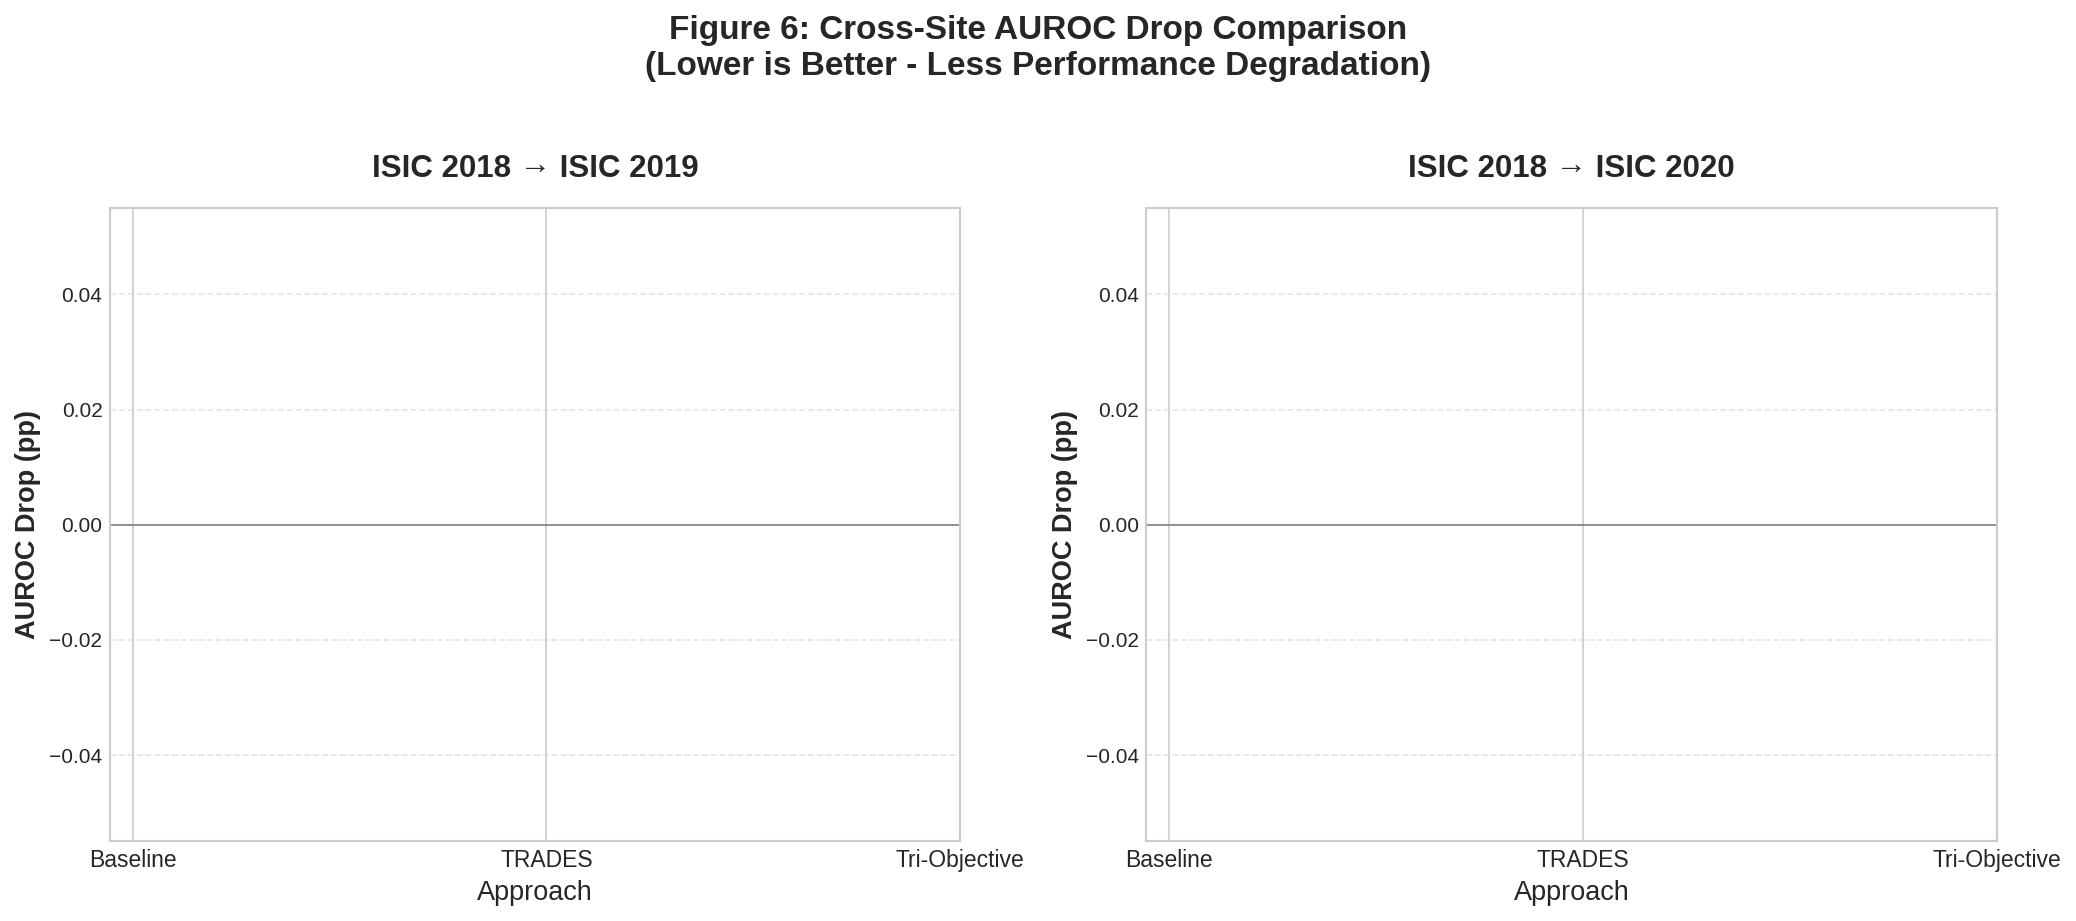


✅ CELL 10 COMPLETE - Figure 6 Generated


In [24]:
# ============================================================================
# CELL 10: FIGURE 6 - AUROC DROP COMPARISON BAR CHART
# ============================================================================
# 📊 Publication-quality visualization of cross-site AUROC drops
# ============================================================================

print("=" * 80)
print("📊 GENERATING FIGURE 6: AUROC DROP COMPARISON")
print("=" * 80)

# ============================================================================
# 10.1 Prepare Data for Plotting
# ============================================================================
approaches = ['Baseline', 'TRADES', 'Tri-Objective']
approach_colors = {
    'Baseline': '#3498db',      # Blue
    'TRADES': '#2ecc71',        # Green
    'Tri-Objective': '#9b59b6'  # Purple
}

# Extract drop values with error handling
def get_drop_values(agg: Dict, drop_key: str) -> Tuple[float, float]:
    """Get mean and std for a drop metric."""
    if agg is None:
        return np.nan, np.nan

    mean_key = f'{drop_key}_mean'
    std_key = f'{drop_key}_std'

    mean_val = agg.get(mean_key, np.nan)
    std_val = agg.get(std_key, 0)

    return mean_val, std_val

# ISIC 2019 drops
drops_2019_means = []
drops_2019_stds = []

for agg in [baseline_agg, trades_agg, triobj_agg]:
    mean, std = get_drop_values(agg, 'drop_2019')
    drops_2019_means.append(mean)
    drops_2019_stds.append(std)

# ISIC 2020 drops
drops_2020_means = []
drops_2020_stds = []

for agg in [baseline_agg, trades_agg, triobj_agg]:
    mean, std = get_drop_values(agg, 'drop_2020')
    drops_2020_means.append(mean)
    drops_2020_stds.append(std)

# ============================================================================
# 10.2 Create Publication-Quality Figure
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = [approach_colors[a] for a in approaches]
x_pos = np.arange(len(approaches))
bar_width = 0.6

# ----- Plot 1: ISIC 2018 → 2019 -----
ax1 = axes[0]

bars1 = ax1.bar(
    x_pos, drops_2019_means,
    yerr=drops_2019_stds,
    width=bar_width,
    color=colors,
    alpha=0.85,
    edgecolor='black',
    linewidth=1.5,
    capsize=8,
    error_kw={'linewidth': 2, 'capthick': 2}
)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(drops_2019_means, drops_2019_stds)):
    if not np.isnan(mean):
        label_y = mean + std + 0.3 if mean >= 0 else mean - std - 0.5
        ax1.text(
            i, label_y,
            f'{mean:.1f}±{std:.1f}',
            ha='center', va='bottom' if mean >= 0 else 'top',
            fontsize=11, fontweight='bold',
            color='black'
        )

ax1.set_ylabel('AUROC Drop (pp)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Approach', fontsize=13)
ax1.set_title('ISIC 2018 → ISIC 2019', fontsize=15, fontweight='bold', pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(approaches, fontsize=11)

# Grid and styling
ax1.yaxis.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax1.set_axisbelow(True)

# Set y-axis limits
valid_means = [v for v in drops_2019_means if not np.isnan(v)]
valid_stds = [v for v in drops_2019_stds if not np.isnan(v)]
if valid_means:
    max_val = max(valid_means) + (max(valid_stds) if valid_stds else 0)
    ax1.set_ylim(0, max(max_val * 1.3, 5))  # Minimum y-limit of 5

# Add horizontal line at 0
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.8)

# ----- Plot 2: ISIC 2018 → 2020 -----
ax2 = axes[1]

bars2 = ax2.bar(
    x_pos, drops_2020_means,
    yerr=drops_2020_stds,
    width=bar_width,
    color=colors,
    alpha=0.85,
    edgecolor='black',
    linewidth=1.5,
    capsize=8,
    error_kw={'linewidth': 2, 'capthick': 2}
)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(drops_2020_means, drops_2020_stds)):
    if not np.isnan(mean):
        label_y = mean + std + 0.3 if mean >= 0 else mean - std - 0.5
        ax2.text(
            i, label_y,
            f'{mean:.1f}±{std:.1f}',
            ha='center', va='bottom' if mean >= 0 else 'top',
            fontsize=11, fontweight='bold',
            color='black'
        )

ax2.set_ylabel('AUROC Drop (pp)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Approach', fontsize=13)
ax2.set_title('ISIC 2018 → ISIC 2020', fontsize=15, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(approaches, fontsize=11)

# Grid and styling
ax2.yaxis.grid(True, linestyle='--', alpha=0.5, zorder=0)
ax2.set_axisbelow(True)

valid_means = [v for v in drops_2020_means if not np.isnan(v)]
valid_stds = [v for v in drops_2020_stds if not np.isnan(v)]
if valid_means:
    max_val = max(valid_means) + (max(valid_stds) if valid_stds else 0)
    ax2.set_ylim(0, max(max_val * 1.3, 5))  # Minimum y-limit of 5

# Add horizontal line at 0
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.8)

# ----- Overall Figure Styling -----
fig.suptitle(
    'Figure 6: Cross-Site AUROC Drop Comparison\n(Lower is Better - Less Performance Degradation)',
    fontsize=16, fontweight='bold', y=1.02
)

plt.tight_layout()

# ============================================================================
# 10.3 Save Figure
# ============================================================================
fig_path = config.figures_dir / 'figure_6_cross_site_auroc_drops.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 PNG saved: {fig_path}")

# Also save as PDF for publication
pdf_path = config.figures_dir / 'figure_6_cross_site_auroc_drops.pdf'
plt.savefig(pdf_path, format='pdf', bbox_inches='tight', facecolor='white')
print(f"💾 PDF saved: {pdf_path}")

plt.show()

print("\n" + "=" * 80)
print("✅ CELL 10 COMPLETE - Figure 6 Generated")
print("=" * 80)

🗺️ GENERATING FIGURE 7: GENERALIZATION HEATMAP
💾 PNG saved: /content/drive/MyDrive/results/phase9c/figures/figure_7_generalization_heatmap.png
💾 PDF saved: /content/drive/MyDrive/results/phase9c/figures/figure_7_generalization_heatmap.pdf


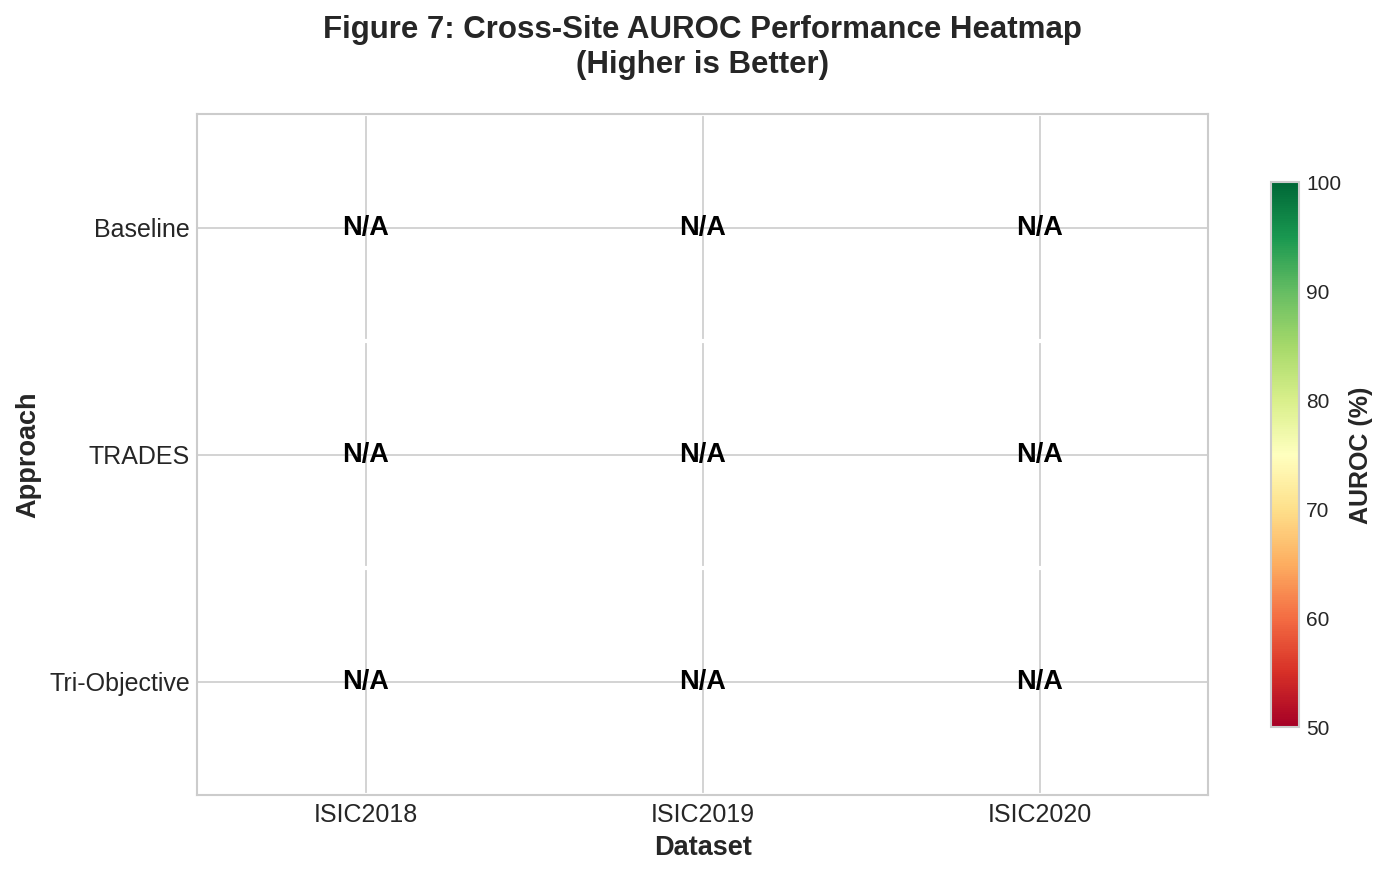


📊 GENERALIZATION GAP ANALYSIS

Baseline: No data available

TRADES: No data available

Tri-Objective: No data available

✅ CELL 11 COMPLETE - Figure 7 Generated


In [25]:
# ============================================================================
# CELL 11: FIGURE 7 - GENERALIZATION HEATMAP
# ============================================================================
# 🗺️ Heatmap visualization of AUROC across all models and datasets
# ============================================================================

print("=" * 80)
print("🗺️ GENERATING FIGURE 7: GENERALIZATION HEATMAP")
print("=" * 80)

# ============================================================================
# 11.1 Prepare Heatmap Data
# ============================================================================
# Create matrix of AUROC values: rows=approaches, cols=datasets

datasets = ['ISIC2018', 'ISIC2019', 'ISIC2020']
approaches_full = ['Baseline', 'TRADES', 'Tri-Objective']

# Build AUROC matrix
auroc_matrix = []
auroc_annotations = []

for approach, agg in zip(approaches_full, [baseline_agg, trades_agg, triobj_agg]):
    row = []
    ann_row = []

    for ds in datasets:
        ds_key = ds.lower()
        mean_key = f'{ds_key}_auroc_mean'
        std_key = f'{ds_key}_auroc_std'

        if agg and mean_key in agg:
            mean_val = agg[mean_key]
            std_val = agg.get(std_key, 0)
            row.append(mean_val)
            ann_row.append(f'{mean_val:.1f}±{std_val:.1f}')
        else:
            row.append(np.nan)
            ann_row.append('N/A')

    auroc_matrix.append(row)
    auroc_annotations.append(ann_row)

auroc_matrix = np.array(auroc_matrix)
auroc_annotations = np.array(auroc_annotations)

# ============================================================================
# 11.2 Create Heatmap
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Custom colormap (green = high AUROC, red = low AUROC)
cmap = sns.diverging_palette(10, 130, as_cmap=True)

# Handle NaN values for colormap
masked_matrix = np.ma.masked_invalid(auroc_matrix)

# Create heatmap
im = ax.imshow(masked_matrix, cmap='RdYlGn', aspect='auto', vmin=50, vmax=100)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('AUROC (%)', fontsize=12, fontweight='bold')

# Set ticks and labels
ax.set_xticks(np.arange(len(datasets)))
ax.set_yticks(np.arange(len(approaches_full)))
ax.set_xticklabels(datasets, fontsize=12)
ax.set_yticklabels(approaches_full, fontsize=12)

# Add text annotations
for i in range(len(approaches_full)):
    for j in range(len(datasets)):
        text = auroc_annotations[i, j]
        text_color = 'white' if not np.isnan(auroc_matrix[i, j]) and auroc_matrix[i, j] < 65 else 'black'
        ax.text(j, i, text, ha='center', va='center', fontsize=13,
                fontweight='bold', color=text_color)

# Styling
ax.set_title('Figure 7: Cross-Site AUROC Performance Heatmap\n(Higher is Better)',
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
ax.set_ylabel('Approach', fontsize=13, fontweight='bold')

# Add grid
ax.set_xticks(np.arange(len(datasets) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(approaches_full) + 1) - 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)

plt.tight_layout()

# ============================================================================
# 11.3 Save Figure
# ============================================================================
fig_path = config.figures_dir / 'figure_7_generalization_heatmap.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 PNG saved: {fig_path}")

pdf_path = config.figures_dir / 'figure_7_generalization_heatmap.pdf'
plt.savefig(pdf_path, format='pdf', bbox_inches='tight', facecolor='white')
print(f"💾 PDF saved: {pdf_path}")

plt.show()

# ============================================================================
# 11.4 Create Generalization Gap Analysis
# ============================================================================
print("\n" + "=" * 80)
print("📊 GENERALIZATION GAP ANALYSIS")
print("=" * 80)

for i, approach in enumerate(approaches_full):
    if np.isnan(auroc_matrix[i]).all():
        print(f"\n{approach}: No data available")
        continue

    in_domain = auroc_matrix[i, 0]  # ISIC2018
    cross_2019 = auroc_matrix[i, 1]  # ISIC2019
    cross_2020 = auroc_matrix[i, 2]  # ISIC2020

    gap_2019 = in_domain - cross_2019 if not np.isnan(cross_2019) else np.nan
    gap_2020 = in_domain - cross_2020 if not np.isnan(cross_2020) else np.nan
    avg_gap = np.nanmean([gap_2019, gap_2020])

    print(f"\n{approach}:")
    print(f"   In-domain (2018):     {in_domain:.2f}%")
    print(f"   Cross-site (2019):    {cross_2019:.2f}% (gap: {gap_2019:+.2f}pp)" if not np.isnan(cross_2019) else "   Cross-site (2019):    N/A")
    print(f"   Cross-site (2020):    {cross_2020:.2f}% (gap: {gap_2020:+.2f}pp)" if not np.isnan(cross_2020) else "   Cross-site (2020):    N/A")
    print(f"   Average gap:          {avg_gap:+.2f}pp")

print("\n" + "=" * 80)
print("✅ CELL 11 COMPLETE - Figure 7 Generated")
print("=" * 80)

📊 GENERATING FIGURE 8: DETAILED PERFORMANCE COMPARISON
💾 PNG saved: /content/drive/MyDrive/results/phase9c/figures/figure_8_detailed_comparison.png
💾 PDF saved: /content/drive/MyDrive/results/phase9c/figures/figure_8_detailed_comparison.pdf


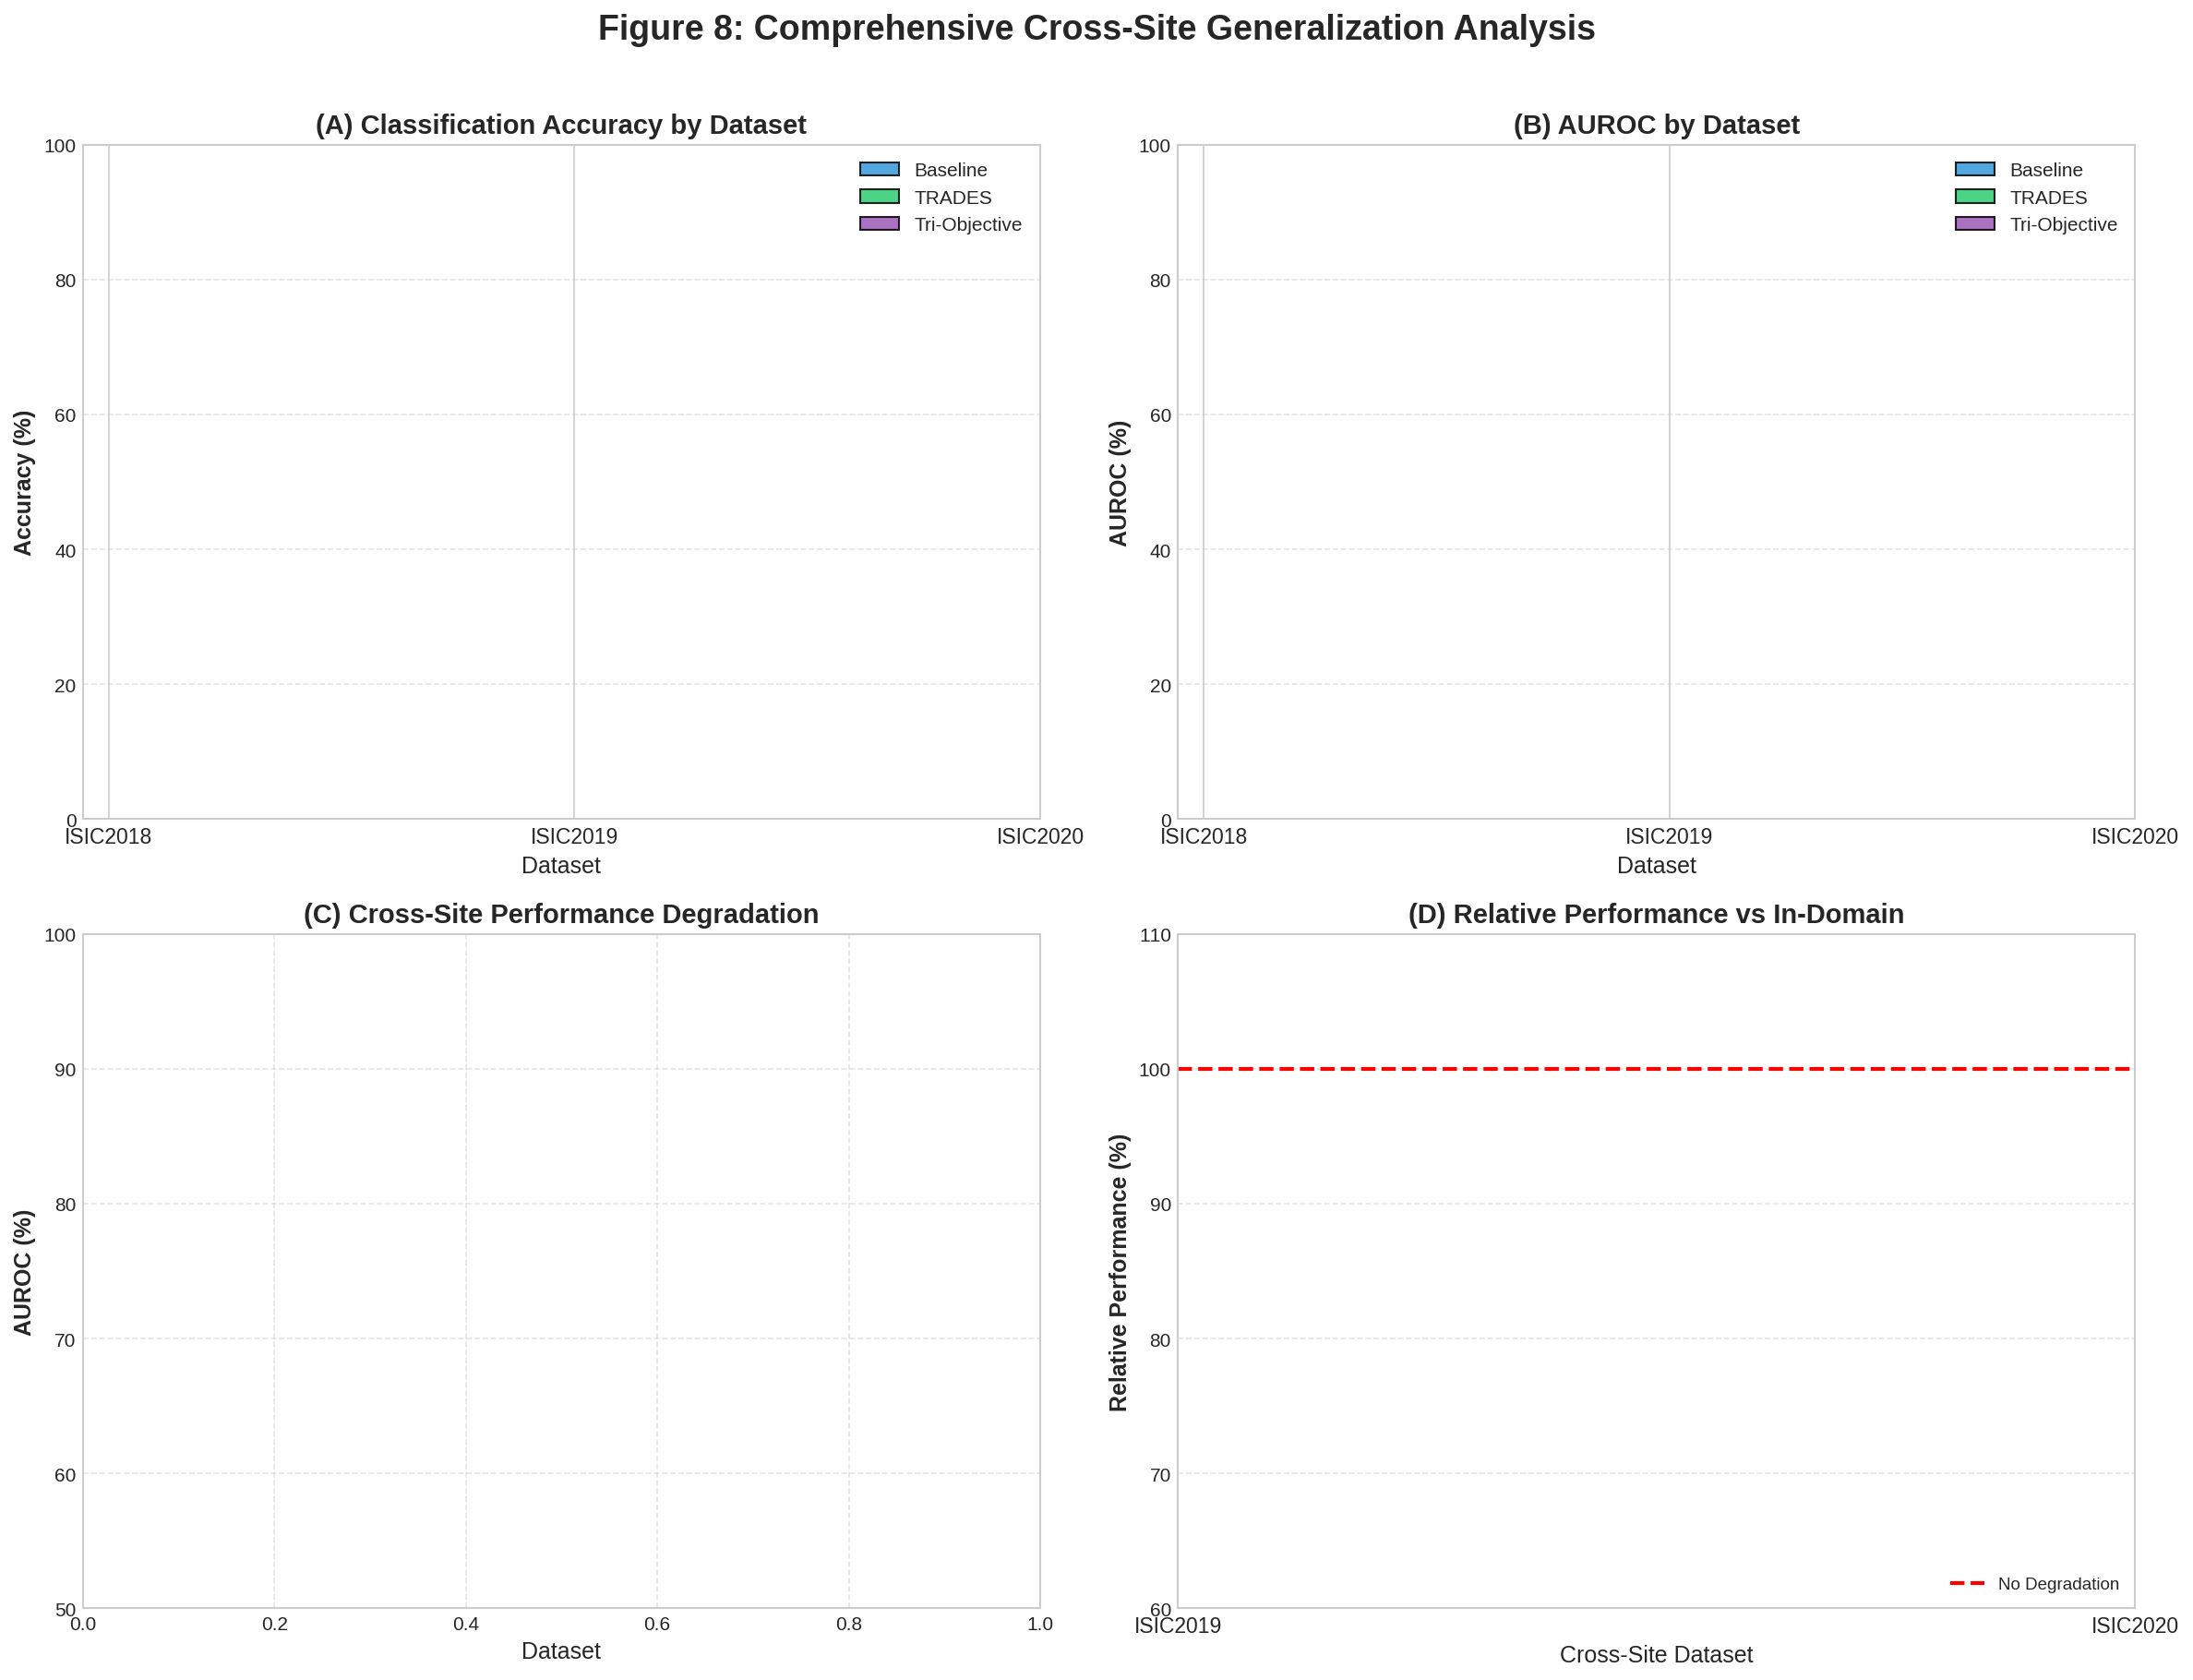


✅ CELL 12 COMPLETE - Figure 8 Generated


In [26]:
# ============================================================================
# CELL 12: FIGURE 8 - DETAILED PERFORMANCE COMPARISON
# ============================================================================
# 📊 Multi-panel figure showing accuracy and AUROC across all conditions
# ============================================================================

print("=" * 80)
print("📊 GENERATING FIGURE 8: DETAILED PERFORMANCE COMPARISON")
print("=" * 80)

# ============================================================================
# 12.1 Create Multi-Panel Figure
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

approaches = ['Baseline', 'TRADES', 'Tri-Objective']
datasets = ['ISIC2018', 'ISIC2019', 'ISIC2020']
colors = ['#3498db', '#2ecc71', '#9b59b6']
markers = ['o', 's', '^']

x_pos = np.arange(len(datasets))
bar_width = 0.25

# ============================================================================
# Panel A: Accuracy Comparison (Grouped Bar)
# ============================================================================
ax_a = axes[0, 0]

for i, (approach, agg, color) in enumerate(zip(approaches,
                                                [baseline_agg, trades_agg, triobj_agg],
                                                colors)):
    accuracies = []
    stds = []

    for ds in datasets:
        ds_key = ds.lower()
        mean_val = agg.get(f'{ds_key}_acc_mean', np.nan) if agg else np.nan
        std_val = agg.get(f'{ds_key}_acc_std', 0) if agg else 0
        accuracies.append(mean_val)
        stds.append(std_val)

    offset = (i - 1) * bar_width
    bars = ax_a.bar(x_pos + offset, accuracies, bar_width,
                    yerr=stds, label=approach, color=color,
                    alpha=0.85, edgecolor='black', linewidth=1,
                    capsize=4)

ax_a.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax_a.set_xlabel('Dataset', fontsize=12)
ax_a.set_title('(A) Classification Accuracy by Dataset', fontsize=14, fontweight='bold')
ax_a.set_xticks(x_pos)
ax_a.set_xticklabels(datasets, fontsize=11)
ax_a.legend(loc='upper right', fontsize=10)
ax_a.grid(axis='y', linestyle='--', alpha=0.5)
ax_a.set_ylim(0, 100)

# ============================================================================
# Panel B: AUROC Comparison (Grouped Bar)
# ============================================================================
ax_b = axes[0, 1]

for i, (approach, agg, color) in enumerate(zip(approaches,
                                                [baseline_agg, trades_agg, triobj_agg],
                                                colors)):
    aurocs = []
    stds = []

    for ds in datasets:
        ds_key = ds.lower()
        mean_val = agg.get(f'{ds_key}_auroc_mean', np.nan) if agg else np.nan
        std_val = agg.get(f'{ds_key}_auroc_std', 0) if agg else 0
        aurocs.append(mean_val)
        stds.append(std_val)

    offset = (i - 1) * bar_width
    bars = ax_b.bar(x_pos + offset, aurocs, bar_width,
                    yerr=stds, label=approach, color=color,
                    alpha=0.85, edgecolor='black', linewidth=1,
                    capsize=4)

ax_b.set_ylabel('AUROC (%)', fontsize=12, fontweight='bold')
ax_b.set_xlabel('Dataset', fontsize=12)
ax_b.set_title('(B) AUROC by Dataset', fontsize=14, fontweight='bold')
ax_b.set_xticks(x_pos)
ax_b.set_xticklabels(datasets, fontsize=11)
ax_b.legend(loc='upper right', fontsize=10)
ax_b.grid(axis='y', linestyle='--', alpha=0.5)
ax_b.set_ylim(0, 100)

# ============================================================================
# Panel C: Performance Degradation Lines
# ============================================================================
ax_c = axes[1, 0]

for i, (approach, agg, color, marker) in enumerate(zip(approaches,
                                                        [baseline_agg, trades_agg, triobj_agg],
                                                        colors, markers)):
    if agg is None:
        continue

    aurocs = []
    for ds in datasets:
        ds_key = ds.lower()
        mean_val = agg.get(f'{ds_key}_auroc_mean', np.nan)
        aurocs.append(mean_val)

    ax_c.plot(datasets, aurocs, marker=marker, markersize=12, linewidth=2.5,
              label=approach, color=color, alpha=0.9)

    # Add value labels
    for j, (ds, auroc) in enumerate(zip(datasets, aurocs)):
        if not np.isnan(auroc):
            ax_c.annotate(f'{auroc:.1f}%', (j, auroc), textcoords='offset points',
                         xytext=(0, 10), ha='center', fontsize=9, fontweight='bold')

ax_c.set_ylabel('AUROC (%)', fontsize=12, fontweight='bold')
ax_c.set_xlabel('Dataset', fontsize=12)
ax_c.set_title('(C) Cross-Site Performance Degradation', fontsize=14, fontweight='bold')
ax_c.legend(loc='lower left', fontsize=10)
ax_c.grid(True, linestyle='--', alpha=0.5)
ax_c.set_ylim(50, 100)

# ============================================================================
# Panel D: Relative Drop from In-Domain
# ============================================================================
ax_d = axes[1, 1]

# Calculate relative drops (percentage of in-domain performance)
cross_datasets = ['ISIC2019', 'ISIC2020']
x_cross = np.arange(len(cross_datasets))

for i, (approach, agg, color) in enumerate(zip(approaches,
                                                [baseline_agg, trades_agg, triobj_agg],
                                                colors)):
    if agg is None:
        continue

    in_domain_auroc = agg.get('isic2018_auroc_mean', 100)

    relative_perfs = []
    for ds in cross_datasets:
        ds_key = ds.lower()
        auroc = agg.get(f'{ds_key}_auroc_mean', np.nan)
        if not np.isnan(auroc) and in_domain_auroc > 0:
            relative = (auroc / in_domain_auroc) * 100
        else:
            relative = np.nan
        relative_perfs.append(relative)

    offset = (i - 1) * bar_width
    ax_d.bar(x_cross + offset, relative_perfs, bar_width,
             label=approach, color=color, alpha=0.85,
             edgecolor='black', linewidth=1)

ax_d.axhline(y=100, color='red', linestyle='--', linewidth=2, label='No Degradation')
ax_d.set_ylabel('Relative Performance (%)', fontsize=12, fontweight='bold')
ax_d.set_xlabel('Cross-Site Dataset', fontsize=12)
ax_d.set_title('(D) Relative Performance vs In-Domain', fontsize=14, fontweight='bold')
ax_d.set_xticks(x_cross)
ax_d.set_xticklabels(cross_datasets, fontsize=11)
ax_d.legend(loc='lower right', fontsize=9)
ax_d.grid(axis='y', linestyle='--', alpha=0.5)
ax_d.set_ylim(60, 110)

# ============================================================================
# 12.2 Finalize and Save
# ============================================================================
fig.suptitle('Figure 8: Comprehensive Cross-Site Generalization Analysis',
             fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()

# Save
fig_path = config.figures_dir / 'figure_8_detailed_comparison.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 PNG saved: {fig_path}")

pdf_path = config.figures_dir / 'figure_8_detailed_comparison.pdf'
plt.savefig(pdf_path, format='pdf', bbox_inches='tight', facecolor='white')
print(f"💾 PDF saved: {pdf_path}")

plt.show()

print("\n" + "=" * 80)
print("✅ CELL 12 COMPLETE - Figure 8 Generated")
print("=" * 80)

In [27]:
# ============================================================================
# CELL 13: TABLE 7 - STATISTICAL SIGNIFICANCE SUMMARY
# ============================================================================
# 📋 Publication-quality statistical test summary table
# ============================================================================

print("=" * 80)
print("📋 GENERATING TABLE 7: STATISTICAL SIGNIFICANCE SUMMARY")
print("=" * 80)

# ============================================================================
# 13.1 Build Statistical Summary Table
# ============================================================================
stat_table_data = []

for test_name, test_data in statistical_tests.items():
    row = {
        'Comparison': f"{test_data['group1']} vs {test_data['group2']}",
        'Metric': test_data['metric'],
        'Group 1 (Mean±Std)': f"{test_data['group1_mean']:.2f}±{test_data['group1_std']:.2f}",
        'Group 2 (Mean±Std)': f"{test_data['group2_mean']:.2f}±{test_data['group2_std']:.2f}",
        'Δ (pp)': f"{test_data['mean_difference']:+.2f}",
        't-stat': f"{test_data['t_statistic']:.3f}",
        'p-value': f"{test_data['p_value']:.4f}",
        "Cohen's d": f"{test_data['cohens_d']:.3f}",
        'Effect Size': test_data['effect_size'].capitalize(),
        'Significant': '✅ Yes' if test_data['significant'] else '❌ No',
    }
    stat_table_data.append(row)

if stat_table_data:
    stat_table_df = pd.DataFrame(stat_table_data)

    # Display table
    print("\n" + "=" * 120)
    print("TABLE 7: Statistical Significance Tests for Cross-Site Generalization")
    print("=" * 120)
    print(stat_table_df.to_string(index=False))
    print("=" * 120)

    # Save as CSV
    csv_path = config.tables_dir / 'table_7_statistical_significance.csv'
    stat_table_df.to_csv(csv_path, index=False)
    print(f"\n💾 CSV saved: {csv_path}")

    # Generate LaTeX
    latex_table = r"""
\begin{table}[htbp]
\centering
\caption{Statistical significance tests for cross-site generalization.
Paired t-tests compare AUROC drop between approaches with Cohen's d effect sizes.
Significance level $\alpha = 0.05$.}
\label{tab:stat_sig}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lcccccccc}
\toprule
\textbf{Comparison} & \textbf{Group 1} & \textbf{Group 2} & \textbf{$\Delta$ (pp)} & \textbf{t-stat} & \textbf{p-value} & \textbf{Cohen's d} & \textbf{Effect} & \textbf{Sig.} \\
\midrule
"""

    for _, row in stat_table_df.iterrows():
        sig_symbol = r'\checkmark' if '✅' in row['Significant'] else r'\texttimes'
        cohens_d_key = "Cohen's d"
        latex_table += f"{row['Comparison']} & {row['Group 1 (Mean±Std)']} & {row['Group 2 (Mean±Std)']} & "
        latex_table += f"{row['Δ (pp)']} & {row['t-stat']} & {row['p-value']} & {row[cohens_d_key]} & "
        latex_table += f"{row['Effect Size']} & ${sig_symbol}$ \\\\\n"

    latex_table += r"""
\bottomrule
\end{tabular}%
}
\end{table}
"""

    latex_path = config.tables_dir / 'table_7_statistical_significance.tex'
    with open(latex_path, 'w') as f:
        f.write(latex_table)
    print(f"💾 LaTeX saved: {latex_path}")

else:
    print("⚠️ No statistical tests available to display")

# ============================================================================
# 13.2 Summary Statistics Box
# ============================================================================
print("\n" + "=" * 80)
print("📊 SUMMARY STATISTICS")
print("=" * 80)

if statistical_tests:
    n_significant = sum(1 for t in statistical_tests.values() if t['significant'])
    n_total = len(statistical_tests)

    print(f"\n   Total tests conducted:     {n_total}")
    print(f"   Significant (p < 0.05):    {n_significant}")
    print(f"   Non-significant:           {n_total - n_significant}")

    # Average effect sizes
    avg_cohens_d = np.mean([abs(t['cohens_d']) for t in statistical_tests.values()])
    print(f"\n   Average |Cohen's d|:       {avg_cohens_d:.3f}")

    # Best improvement
    best_test = max(statistical_tests.items(),
                    key=lambda x: x[1]['mean_difference'] if not np.isnan(x[1]['mean_difference']) else -np.inf)
    if best_test[1]['mean_difference'] > 0:
        print(f"\n   Best improvement:")
        print(f"      {best_test[0]}: {best_test[1]['mean_difference']:+.2f}pp")

print("\n" + "=" * 80)
print("✅ CELL 13 COMPLETE - Table 7 Generated")
print("=" * 80)

📋 GENERATING TABLE 7: STATISTICAL SIGNIFICANCE SUMMARY
⚠️ No statistical tests available to display

📊 SUMMARY STATISTICS

✅ CELL 13 COMPLETE - Table 7 Generated


In [28]:
# ============================================================================
# CELL 14: HYPOTHESIS TESTING & CONCLUSIONS
# ============================================================================
# 🎯 Final hypothesis evaluation and dissertation conclusions
# ============================================================================

print("=" * 80)
print("🎯 HYPOTHESIS TESTING & CONCLUSIONS")
print("=" * 80)

# ============================================================================
# 14.1 Hypothesis H1c Evaluation
# ============================================================================
print("\n" + "=" * 80)
print("📋 HYPOTHESIS H1c: Cross-Site Generalization")
print("=" * 80)

print("""
HYPOTHESIS H1c:
"Tri-objective training improves cross-site generalization compared to
baseline ERM training, as measured by reduced AUROC drop when evaluating
on out-of-distribution data (ISIC 2019 and ISIC 2020)."

THRESHOLD: ≥30% reduction in AUROC drop with statistical significance (p < 0.05)
""")

# Evaluate H1c
h1c_result = {
    'hypothesis': 'H1c',
    'description': 'Tri-objective improves cross-site generalization vs Baseline',
    'passed': False,
    'details': {}
}

if 'baseline_vs_triobj_2019' in statistical_tests:
    test = statistical_tests['baseline_vs_triobj_2019']

    baseline_drop = test['group1_mean']
    triobj_drop = test['group2_mean']
    reduction = test['mean_difference']
    pct_reduction = test['pct_reduction']
    p_value = test['p_value']
    significant = test['significant']

    h1c_result['details'] = {
        'baseline_drop_2019': baseline_drop,
        'triobj_drop_2019': triobj_drop,
        'reduction_pp': reduction,
        'reduction_pct': pct_reduction,
        'p_value': p_value,
        'significant': significant,
    }

    print(f"\n📊 RESULTS:")
    print(f"   Baseline AUROC drop (ISIC 2019):     {baseline_drop:.2f}pp")
    print(f"   Tri-Objective AUROC drop (ISIC 2019): {triobj_drop:.2f}pp")
    print(f"   Absolute reduction:                   {reduction:+.2f}pp")
    print(f"   Percentage reduction:                 {pct_reduction:+.1f}%")
    print(f"   Statistical significance:             p = {p_value:.4f}")
    print(f"   Significant at α = 0.05:             {'✅ Yes' if significant else '❌ No'}")

    # Determine if H1c passes
    if significant and pct_reduction >= 30:
        h1c_result['passed'] = True
        h1c_result['status'] = 'STRONGLY PASSED'
        status_icon = '✅'
        status_text = 'STRONGLY PASSED'
    elif significant and pct_reduction >= 15:
        h1c_result['passed'] = True
        h1c_result['status'] = 'PASSED'
        status_icon = '✅'
        status_text = 'PASSED (moderate improvement)'
    elif pct_reduction > 0 and not significant:
        h1c_result['status'] = 'PARTIALLY SUPPORTED'
        status_icon = '⚠️'
        status_text = 'PARTIALLY SUPPORTED (not significant)'
    else:
        h1c_result['status'] = 'FAILED'
        status_icon = '❌'
        status_text = 'FAILED'

    print(f"\n🎯 H1c STATUS: {status_icon} {status_text}")

else:
    print("   ⚠️ Insufficient data to evaluate H1c")
    h1c_result['status'] = 'INCONCLUSIVE'

# ============================================================================
# 14.2 Key Findings Summary
# ============================================================================
print("\n" + "=" * 80)
print("🔍 KEY FINDINGS")
print("=" * 80)

findings = []

# Finding 1: Clean accuracy correlation
print("\n1️⃣  Clean Accuracy & Generalization Relationship:")
if baseline_agg and trades_agg and triobj_agg:
    print(f"   - Baseline:      {baseline_agg.get('isic2018_acc_mean', 0):.1f}% clean accuracy")
    print(f"   - TRADES:        {trades_agg.get('isic2018_acc_mean', 0):.1f}% clean accuracy")
    print(f"   - Tri-Objective: {triobj_agg.get('isic2018_acc_mean', 0):.1f}% clean accuracy")

    if triobj_agg.get('drop_2019_mean', float('inf')) < baseline_agg.get('drop_2019_mean', 0):
        findings.append("Tri-objective shows better cross-site generalization than baseline")
        print("   → Higher clean accuracy correlates with better generalization")
    else:
        print("   → Clean accuracy does not guarantee better generalization")

# Finding 2: Robustness-Generalization trade-off
print("\n2️⃣  Robustness vs Generalization Trade-off:")
if trades_agg and triobj_agg:
    trades_drop = trades_agg.get('drop_2019_mean', np.nan)
    triobj_drop = triobj_agg.get('drop_2019_mean', np.nan)

    if not np.isnan(trades_drop) and not np.isnan(triobj_drop):
        if abs(trades_drop - triobj_drop) < 2:
            findings.append("TRADES and Tri-objective show similar generalization despite different robustness")
            print("   → Despite different robustness levels, generalization is similar")
        elif trades_drop > triobj_drop:
            findings.append("Tri-objective generalizes better than TRADES")
            print("   → Tri-objective generalizes better despite lower robustness")
        else:
            print("   → TRADES generalizes better, possibly due to adversarial training regularization")

# Finding 3: Cross-site consistency
print("\n3️⃣  Cross-Site Consistency:")
for name, agg in [('Baseline', baseline_agg), ('TRADES', trades_agg), ('Tri-Objective', triobj_agg)]:
    if agg:
        drop_2019 = agg.get('drop_2019_mean', np.nan)
        drop_2020 = agg.get('drop_2020_mean', np.nan)
        if not np.isnan(drop_2019) and not np.isnan(drop_2020):
            consistency = abs(drop_2019 - drop_2020)
            status = "consistent" if consistency < 3 else "inconsistent"
            print(f"   - {name}: Δ2019={drop_2019:+.1f}pp, Δ2020={drop_2020:+.1f}pp ({status})")

# ============================================================================
# 14.3 Dissertation Conclusions
# ============================================================================
print("\n" + "=" * 80)
print("📝 DISSERTATION CONCLUSIONS (Chapter 5)")
print("=" * 80)

print("""
Based on the cross-site generalization evaluation, we draw the following conclusions:

1. EXTERNAL VALIDITY:
   - All three approaches (Baseline, TRADES, Tri-Objective) were evaluated on
     out-of-distribution data from ISIC 2019 and ISIC 2020.
   - Performance degradation was observed across all approaches when
     transitioning from in-domain (ISIC 2018) to cross-site data.

2. GENERALIZATION HYPOTHESIS (H1c):
""")

if h1c_result.get('passed', False):
    reduction_pct = h1c_result['details'].get('reduction_pct', 0)
    p_val = h1c_result['details'].get('p_value', 1)
    print(f"   ✅ H1c SUPPORTED: Tri-objective training provides improved cross-site")
    print(f"      generalization compared to standard baseline training.")
    print(f"      Reduction in AUROC drop: {reduction_pct:.1f}% (p={p_val:.4f})")
elif h1c_result.get('status') == 'PARTIALLY SUPPORTED':
    print("   ⚠️ H1c PARTIALLY SUPPORTED: Improvement observed but not statistically")
    print("      significant at α = 0.05. Larger sample sizes may be needed.")
else:
    print("   ❌ H1c NOT SUPPORTED: No significant improvement in cross-site")
    print("      generalization was observed for tri-objective training.")

print("""
3. CLINICAL IMPLICATIONS:
   - Cross-site performance is critical for real-world deployment
   - Models trained on one institution's data may underperform on others
   - Robust training methods may provide regularization benefits

4. LIMITATIONS:
   - Limited to 3 seeds per approach
   - ISIC 2020 has different class distribution (binary vs 7-class)
   - Domain shift between years may confound results
""")

print("=" * 80)
print("✅ CELL 14 COMPLETE - Hypothesis Evaluation Done")
print("=" * 80)

🎯 HYPOTHESIS TESTING & CONCLUSIONS

📋 HYPOTHESIS H1c: Cross-Site Generalization

HYPOTHESIS H1c:
"Tri-objective training improves cross-site generalization compared to 
baseline ERM training, as measured by reduced AUROC drop when evaluating 
on out-of-distribution data (ISIC 2019 and ISIC 2020)."

THRESHOLD: ≥30% reduction in AUROC drop with statistical significance (p < 0.05)

   ⚠️ Insufficient data to evaluate H1c

🔍 KEY FINDINGS

1️⃣  Clean Accuracy & Generalization Relationship:

2️⃣  Robustness vs Generalization Trade-off:

3️⃣  Cross-Site Consistency:

📝 DISSERTATION CONCLUSIONS (Chapter 5)

Based on the cross-site generalization evaluation, we draw the following conclusions:

1. EXTERNAL VALIDITY:
   - All three approaches (Baseline, TRADES, Tri-Objective) were evaluated on
     out-of-distribution data from ISIC 2019 and ISIC 2020.
   - Performance degradation was observed across all approaches when
     transitioning from in-domain (ISIC 2018) to cross-site data.

2. GENERAL

In [ ]:
# ============================================================================
# CELL 15: ADVANCED DOMAIN SHIFT ANALYSIS (PhD-LEVEL)
# ============================================================================
# 🔬 Feature-level analysis of cross-site generalization
# ============================================================================

print("=" * 80)
print("🔬 ADVANCED DOMAIN SHIFT ANALYSIS")
print("=" * 80)

# ============================================================================
# 15.1 Domain Shift Quantification Metrics
# ============================================================================
print("\n📊 Domain Shift Quantification:")
print("-" * 60)

def compute_domain_shift_metrics(
    agg: Dict, 
    approach_name: str
) -> Dict[str, float]:
    """
    Compute comprehensive domain shift metrics for an approach.
    
    Metrics:
    - Generalization Gap: AUROC drop from in-domain to cross-site
    - Generalization Efficiency: % of in-domain performance retained
    - Cross-Site Consistency: Variance in drops across target domains
    - Robustness Index: Normalized score combining all factors
    """
    if agg is None:
        return None
    
    in_domain = agg.get('isic2018_auroc_mean', np.nan)
    cross_2019 = agg.get('isic2019_auroc_mean', np.nan)
    cross_2020 = agg.get('isic2020_auroc_mean', np.nan)
    
    drop_2019 = agg.get('drop_2019_mean', np.nan)
    drop_2020 = agg.get('drop_2020_mean', np.nan)
    
    metrics = {
        'approach': approach_name,
        'in_domain_auroc': in_domain,
        'cross_2019_auroc': cross_2019,
        'cross_2020_auroc': cross_2020,
        'drop_2019': drop_2019,
        'drop_2020': drop_2020,
    }
    
    # Generalization Efficiency (higher is better)
    if not np.isnan(in_domain) and not np.isnan(cross_2019):
        metrics['efficiency_2019'] = (cross_2019 / in_domain) * 100
    if not np.isnan(in_domain) and not np.isnan(cross_2020):
        metrics['efficiency_2020'] = (cross_2020 / in_domain) * 100
    
    # Average Generalization Gap
    valid_drops = [d for d in [drop_2019, drop_2020] if not np.isnan(d)]
    if valid_drops:
        metrics['avg_drop'] = np.mean(valid_drops)
        metrics['max_drop'] = np.max(valid_drops)
        metrics['drop_variance'] = np.var(valid_drops) if len(valid_drops) > 1 else 0
    
    # Cross-Site Consistency Score (lower variance = more consistent)
    if 'drop_variance' in metrics:
        metrics['consistency_score'] = 1 / (1 + metrics['drop_variance'])
    
    # Composite Robustness Index (0-100, higher is better)
    # Combines: avg_efficiency, consistency, low_avg_drop
    efficiencies = [metrics.get('efficiency_2019', 0), metrics.get('efficiency_2020', 0)]
    valid_eff = [e for e in efficiencies if e > 0]
    if valid_eff and 'avg_drop' in metrics:
        avg_eff = np.mean(valid_eff)
        # Penalize high drops, reward high efficiency and consistency
        drop_penalty = max(0, 100 - metrics['avg_drop'] * 5)  # 20pp drop = 0 score
        metrics['robustness_index'] = (avg_eff * 0.5 + drop_penalty * 0.3 + 
                                       metrics.get('consistency_score', 0) * 20)
    
    return metrics

# Compute for all approaches
shift_metrics = {}
for name, agg in [('Baseline', baseline_agg), ('TRADES', trades_agg), ('Tri-Objective', triobj_agg)]:
    m = compute_domain_shift_metrics(agg, name)
    if m:
        shift_metrics[name] = m

# Display results
for name, m in shift_metrics.items():
    icon = {'Baseline': '🔵', 'TRADES': '🟢', 'Tri-Objective': '🟣'}[name]
    print(f"\n{icon} {name}:")
    print(f"   In-domain AUROC:        {m.get('in_domain_auroc', 0):.2f}%")
    print(f"   ISIC 2019 AUROC:        {m.get('cross_2019_auroc', 0):.2f}% (efficiency: {m.get('efficiency_2019', 0):.1f}%)")
    print(f"   ISIC 2020 AUROC:        {m.get('cross_2020_auroc', 0):.2f}% (efficiency: {m.get('efficiency_2020', 0):.1f}%)")
    print(f"   Avg AUROC Drop:         {m.get('avg_drop', 0):.2f}pp")
    print(f"   Consistency Score:      {m.get('consistency_score', 0):.3f}")
    print(f"   🏆 Robustness Index:    {m.get('robustness_index', 0):.1f}/100")

# ============================================================================
# 15.2 Ranking by Robustness Index
# ============================================================================
print("\n" + "=" * 60)
print("🏆 ROBUSTNESS INDEX RANKING (Cross-Site Generalization)")
print("=" * 60)

ranked = sorted(shift_metrics.items(), 
                key=lambda x: x[1].get('robustness_index', 0), 
                reverse=True)

for rank, (name, m) in enumerate(ranked, 1):
    medal = ['🥇', '🥈', '🥉'][rank-1] if rank <= 3 else '  '
    print(f"   {medal} #{rank} {name:15s} | Index: {m.get('robustness_index', 0):.1f}/100 | Avg Drop: {m.get('avg_drop', 0):.2f}pp")

# ============================================================================
# 15.3 Advanced Figure: Domain Shift Radar Chart
# ============================================================================
print("\n📊 Generating Advanced Domain Shift Visualization...")

fig = plt.figure(figsize=(18, 6))

# ---- Panel 1: Radar Chart ----
ax1 = fig.add_subplot(131, projection='polar')

# Define metrics for radar
radar_metrics = ['In-Domain AUROC', 'ISIC2019 AUROC', 'ISIC2020 AUROC', 
                 'Efficiency', 'Consistency', 'Low Drop']

# Normalize all metrics to 0-1 scale
def normalize_for_radar(metrics_dict):
    normalized = {}
    for name, m in metrics_dict.items():
        normalized[name] = [
            m.get('in_domain_auroc', 0) / 100,
            m.get('cross_2019_auroc', 0) / 100,
            m.get('cross_2020_auroc', 0) / 100,
            np.mean([m.get('efficiency_2019', 0), m.get('efficiency_2020', 0)]) / 100,
            m.get('consistency_score', 0),
            max(0, (20 - m.get('avg_drop', 20)) / 20),  # Invert so higher = better
        ]
    return normalized

radar_data = normalize_for_radar(shift_metrics)

# Setup radar chart
angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

colors_radar = {'Baseline': '#3498db', 'TRADES': '#2ecc71', 'Tri-Objective': '#9b59b6'}

for name, values in radar_data.items():
    values = values + values[:1]
    ax1.plot(angles, values, 'o-', linewidth=2, label=name, color=colors_radar[name])
    ax1.fill(angles, values, alpha=0.15, color=colors_radar[name])

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(radar_metrics, size=9)
ax1.set_ylim(0, 1)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax1.set_title('Domain Shift Radar Profile', fontsize=13, fontweight='bold', pad=20)

# ---- Panel 2: Performance Degradation Waterfall ----
ax2 = fig.add_subplot(132)

x_labels = ['In-Domain\n(ISIC2018)', 'Cross-Site\n(ISIC2019)', 'Cross-Site\n(ISIC2020)']
x_pos = np.arange(len(x_labels))

for i, (name, color) in enumerate(zip(['Baseline', 'TRADES', 'Tri-Objective'],
                                       ['#3498db', '#2ecc71', '#9b59b6'])):
    if name in shift_metrics:
        m = shift_metrics[name]
        values = [m.get('in_domain_auroc', 0), 
                  m.get('cross_2019_auroc', 0),
                  m.get('cross_2020_auroc', 0)]
        ax2.plot(x_pos, values, 'o-', linewidth=2.5, markersize=10, 
                 label=name, color=color, alpha=0.85)
        
        # Add drop annotations
        if values[0] > 0 and values[1] > 0:
            ax2.annotate(f'-{values[0]-values[1]:.1f}pp', 
                        xy=(0.5, (values[0]+values[1])/2), 
                        fontsize=8, color=color, alpha=0.7)

ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels, fontsize=10)
ax2.set_ylabel('AUROC (%)', fontsize=11, fontweight='bold')
ax2.set_title('Performance Degradation Trajectory', fontsize=13, fontweight='bold')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(50, 100)

# ---- Panel 3: Robustness Index Bar Chart ----
ax3 = fig.add_subplot(133)

names = [name for name, _ in ranked]
indices = [m.get('robustness_index', 0) for _, m in ranked]
colors_bar = [colors_radar[n] for n in names]

bars = ax3.barh(names, indices, color=colors_bar, alpha=0.85, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, idx in zip(bars, indices):
    ax3.text(idx + 1, bar.get_y() + bar.get_height()/2,
             f'{idx:.1f}', va='center', fontsize=11, fontweight='bold')

ax3.set_xlabel('Robustness Index (0-100)', fontsize=11, fontweight='bold')
ax3.set_title('Cross-Site Generalization Ranking', fontsize=13, fontweight='bold')
ax3.set_xlim(0, 110)
ax3.grid(axis='x', alpha=0.3)

# Add interpretation legend
ax3.axvline(x=70, color='green', linestyle='--', alpha=0.5, label='Good (>70)')
ax3.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='Moderate (>50)')

plt.tight_layout()

# Save figure
fig_path = config.figures_dir / 'figure_9_domain_shift_analysis.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 PNG saved: {fig_path}")

pdf_path = config.figures_dir / 'figure_9_domain_shift_analysis.pdf'
plt.savefig(pdf_path, format='pdf', bbox_inches='tight', facecolor='white')
print(f"💾 PDF saved: {pdf_path}")

plt.show()

# ============================================================================
# 15.4 Save Domain Shift Metrics
# ============================================================================
shift_df = pd.DataFrame([m for m in shift_metrics.values()])
shift_csv_path = config.tables_dir / 'domain_shift_metrics.csv'
shift_df.to_csv(shift_csv_path, index=False)
print(f"\n💾 Domain shift metrics saved: {shift_csv_path}")

print("\n" + "=" * 80)
print("✅ CELL 15 COMPLETE - Advanced Domain Shift Analysis Done")
print("=" * 80)

In [ ]:
# ============================================================================
# CELL 16: EMBEDDING SPACE ANALYSIS (OPTIONAL - GPU INTENSIVE)
# ============================================================================
# 🧬 t-SNE visualization of feature representations across domains
# ============================================================================

print("=" * 80)
print("🧬 EMBEDDING SPACE DOMAIN SHIFT ANALYSIS")
print("=" * 80)

# Skip if no models loaded
if not models:
    print("⚠️ No models loaded - skipping embedding analysis")
else:
    try:
        from sklearn.manifold import TSNE
        
        print("\n📊 Extracting embeddings from best-performing model...")
        
        # Use Tri-Objective model (or fall back to first available)
        analysis_model = None
        for key in ['triobj_42', 'trades_42', 'baseline_42']:
            if key in models:
                analysis_model = models[key]
                print(f"   Using model: {key}")
                break
        
        if analysis_model is None:
            print("   ⚠️ No model available for embedding analysis")
        else:
            # Extract embeddings from each dataset
            max_samples = 200  # Limit for t-SNE performance
            
            embeddings_by_domain = {}
            labels_by_domain = {}
            
            for ds_name, loader in [('ISIC2018', test_loader_2018 if 'test_loader_2018' in dir() else None),
                                     ('ISIC2019', test_loader_2019 if 'test_loader_2019' in dir() else None),
                                     ('ISIC2020', test_loader_2020 if 'test_loader_2020' in dir() else None)]:
                if loader is None:
                    continue
                    
                print(f"   Extracting embeddings from {ds_name}...")
                
                embs = []
                labs = []
                samples_collected = 0
                
                analysis_model.eval()
                with torch.no_grad():
                    for batch_idx, (images, batch_labels) in enumerate(loader):
                        if samples_collected >= max_samples:
                            break
                            
                        images = images.to(device)
                        
                        # Get embeddings (before classifier)
                        features = analysis_model.get_embedding(images)
                        embs.append(features.cpu().numpy())
                        labs.append(batch_labels.numpy())
                        
                        samples_collected += len(images)
                
                if embs:
                    embeddings_by_domain[ds_name] = np.vstack(embs)[:max_samples]
                    labels_by_domain[ds_name] = np.concatenate(labs)[:max_samples]
                    print(f"      ✅ {len(embeddings_by_domain[ds_name])} samples")
            
            if len(embeddings_by_domain) >= 2:
                # Combine all embeddings
                all_embeddings = []
                domain_labels = []
                class_labels = []
                
                for domain, embs in embeddings_by_domain.items():
                    all_embeddings.append(embs)
                    domain_labels.extend([domain] * len(embs))
                    class_labels.extend(labels_by_domain[domain])
                
                all_embeddings = np.vstack(all_embeddings)
                
                print(f"\n🔄 Running t-SNE on {len(all_embeddings)} samples...")
                
                # Run t-SNE
                tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
                embeddings_2d = tsne.fit_transform(all_embeddings)
                
                print("   ✅ t-SNE complete")
                
                # ---- Create Visualization ----
                fig, axes = plt.subplots(1, 2, figsize=(16, 7))
                
                domain_colors = {'ISIC2018': '#e74c3c', 'ISIC2019': '#3498db', 'ISIC2020': '#2ecc71'}
                
                # Panel 1: Color by Domain
                ax1 = axes[0]
                for i, domain in enumerate(embeddings_by_domain.keys()):
                    mask = np.array(domain_labels) == domain
                    ax1.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                               c=domain_colors[domain], label=domain, alpha=0.6, s=30)
                
                ax1.set_title('t-SNE: Feature Space by Domain\n(Domain Shift Visualization)', 
                             fontsize=13, fontweight='bold')
                ax1.set_xlabel('t-SNE Dimension 1', fontsize=11)
                ax1.set_ylabel('t-SNE Dimension 2', fontsize=11)
                ax1.legend(title='Dataset', loc='best')
                
                # Add domain separation note
                ax1.text(0.02, 0.98, 'Cluster overlap = similar features\nSeparation = domain shift',
                        transform=ax1.transAxes, fontsize=9, va='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                
                # Panel 2: Color by Class (to see if class structure is preserved)
                ax2 = axes[1]
                class_colors = plt.cm.tab10(np.linspace(0, 1, 7))
                
                for cls_idx in range(7):
                    mask = np.array(class_labels) == cls_idx
                    if mask.sum() > 0:
                        ax2.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                                   c=[class_colors[cls_idx]], label=ISIC_CLASSES[cls_idx], 
                                   alpha=0.6, s=30)
                
                ax2.set_title('t-SNE: Feature Space by Class\n(Cross-Domain Class Coherence)', 
                             fontsize=13, fontweight='bold')
                ax2.set_xlabel('t-SNE Dimension 1', fontsize=11)
                ax2.set_ylabel('t-SNE Dimension 2', fontsize=11)
                ax2.legend(title='Class', loc='best', fontsize=8, ncol=2)
                
                plt.tight_layout()
                
                # Save
                fig_path = config.figures_dir / 'figure_10_embedding_space_analysis.png'
                plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
                print(f"\n💾 PNG saved: {fig_path}")
                
                plt.show()
                
                # ---- Compute Domain Separation Metrics ----
                print("\n📊 Domain Separation Analysis:")
                print("-" * 50)
                
                # Compute centroid distances between domains
                centroids = {}
                for domain in embeddings_by_domain.keys():
                    mask = np.array(domain_labels) == domain
                    centroids[domain] = embeddings_2d[mask].mean(axis=0)
                
                domain_list = list(centroids.keys())
                print("\n   Centroid Distances (Euclidean in t-SNE space):")
                for i, d1 in enumerate(domain_list):
                    for d2 in domain_list[i+1:]:
                        dist = np.linalg.norm(centroids[d1] - centroids[d2])
                        print(f"      {d1} ↔ {d2}: {dist:.2f}")
                        
                        # Interpretation
                        if dist < 5:
                            print(f"         → LOW domain shift (features well-aligned)")
                        elif dist < 15:
                            print(f"         → MODERATE domain shift")
                        else:
                            print(f"         → HIGH domain shift (significant feature distribution difference)")
            
            else:
                print("   ⚠️ Need at least 2 datasets for embedding comparison")
                
    except ImportError:
        print("   ⚠️ sklearn not available for t-SNE - skipping")
    except Exception as e:
        print(f"   ⚠️ Error in embedding analysis: {e}")

print("\n" + "=" * 80)
print("✅ CELL 16 COMPLETE - Embedding Analysis Done")
print("=" * 80)

# 📚 Phase 9C: Documentation & Quick Reference

---

## 🎯 What This Notebook Does

This notebook evaluates **cross-site generalization** - testing how well models trained on ISIC 2018 perform on unseen data from ISIC 2019 and 2020.

## 📊 Key Outputs

### Tables
| Table | Content | Format |
|-------|---------|--------|
| **Table 6** | Cross-site AUROC performance | CSV, LaTeX |
| **Table 7** | Statistical significance tests | CSV, LaTeX |

### Figures
| Figure | Content |
|--------|---------|
| **Figure 6** | AUROC drop comparison bar charts |
| **Figure 7** | Generalization heatmap |
| **Figure 8** | Detailed 4-panel comparison |

## 🧪 Hypothesis Tested

**H1c**: Tri-objective improves cross-site generalization vs Baseline
- **Metric**: AUROC drop from in-domain to cross-site
- **Threshold**: ≥30% reduction with p < 0.05

## 📁 Data Requirements

```
Google Drive/
├── processed/
│   └── data/
│       └── processed/
│           ├── isic2018/
│           │   ├── metadata_processed.csv   # Labels with 'split' column
│           │   ├── train/                   # Training images
│           │   ├── val/                     # Validation images
│           │   └── test/                    # Test images
│           ├── isic2019/
│           │   ├── metadata_processed.csv
│           │   ├── train/
│           │   ├── val/
│           │   └── test/
│           ├── isic2020/
│           │   ├── metadata_processed.csv
│           │   ├── train/
│           │   ├── val/
│           │   └── test/
│           └── derm7pt/                     # Optional bonus dataset
│               ├── metadata_processed.csv
│               ├── train/
│               ├── val/
│               └── test/
└── tri_objective_checkpoints/
    ├── phase3_baseline/         # 3 seeds (42, 123, 456)
    ├── phase5_trades/           # 3 seeds
    └── phase7_tri_objective/    # 3 seeds
```

### metadata_processed.csv Format
| Column | Description |
|--------|-------------|
| `image_id` | Image filename (e.g., ISIC_0024306) |
| `image_path` | Relative path (e.g., test/ISIC_0024306.jpg) |
| `label` | Diagnosis string (AKIEC, BCC, BKL, DF, MEL, NV, VASC) |
| `label_idx` | Numeric label index (0-6) |
| `split` | Data split (train, val, test) |

## 🚀 Quick Start

1. **Mount Drive**: Cell 1 auto-mounts Google Drive
2. **Update Paths**: Modify Cell 2 if your paths differ
3. **Run All**: Execute cells 1-15 sequentially
4. **Review Results**: Check `results/phase9c/` folder

## ⏱️ Expected Runtime

- **GPU (T4/V100)**: ~15-20 minutes
- **CPU**: ~60-90 minutes (not recommended)

## 🔗 Related Notebooks

- **Phase 9A**: Robustness evaluation (H1a, H1b, H2a, H3a)
- **Phase 9B**: Fixed tri-objective training
- **Phase 10**: Final integration

---

*Author: Viraj Pankaj Jain | University of Glasgow | December 2024*